In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter
%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
from __future__ import print_function
try:
    import numpy as np
except ImportError:
    np = None
def nominal_metric(a, b):
    return a != b
def interval_metric(a, b):
    return (a-b)**2
def ratio_metric(a, b):
    return ((a-b)/(a+b))**2
def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or 
    it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.

In [3]:
label2int = {'agrees':1,'neutral':0,'disagrees':-1}
N_WORKERS = 8  # number of workers per batch
N_BATCHES = 10 # number of batches per round
N_ROUNDS = 5   # number of rounds (so far)
BATCH_NOS = list(range(0,N_BATCHES))

## Contents

1. [TO DO](#TO-DO)
1. [Load data](#Load-data)
  1. [Clean subject and trial data](#Clean-subject-and-trial-data)
1. [Examine general subject demographics](#Examine-general-subject-demographics)
  1. [Per round](#Per-round)
    1. [Round 1](#Round-1)
    1. [Round 2](#Round-2)
    1. [Round 3](#Round-3)
  1. [On aggregate](#On-aggregate)
1. [Examine RTs](#Examine-RTs)
1. [Examine poll responses](#Examine-responses-to-poll-Qs)
1. [Format trial data](#Format-trial-data)
1. [Generate MACE scores](#Generate-MACE-scores)
1. [IAA](#IAA)
1. [Analysis](#Analysis)
1. [Extras](#Extras)
  1. [Matching annotations to original complement clauses](#Matching-annotations-to-original-complement-clauses)
  1. [Pilots](#PILOTS)
  1. [IAA Me and Dallas](#IAA-Me-and-Dallas)

# TO DO
- see how people responded to "orchestrated mislead" item in Round 3 Batch 8

# Load data

Load annotation items used for each batch, per round.

In [4]:
ROUND_DATA = {i: pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
LIVE_ROUND{}_BATCH_DATA.pkl'.format(i),'rb')) for i in [n+1 for n in range(N_ROUNDS)]}

In [53]:
pd.DataFrame(ROUND_DATA[2][9]).set_index('sent_id')

,sentence,option1,option2,option3,condition,df_key
sent_id,,,,,,
s0,Global warming is a hoax.,agrees,disagrees,neutral,screen,-1
s1,Alarming levels of sea level rise are predicte...,agrees,disagrees,neutral,screen,-1
s2,"Over the past several years, the United States...",agrees,disagrees,neutral,screen,-1
s3,Global warming is happening and it will be dan...,agrees,disagrees,neutral,screen,-1
s4,Some icebergs are cute.,agrees,disagrees,neutral,screen,-1
t0,Total ice accumulation on Antarctica has outwe...,agrees,disagrees,neutral,true,16982
t1,Global warming has been at a plateau since 1990.,agrees,disagrees,neutral,true,16860
t2,There’s no question that humans have altered t...,agrees,disagrees,neutral,true,3811
t3,Reducing carbon emissions to zero could be a m...,agrees,disagrees,neutral,true,3685


## Clean subject and trial data

In [7]:
def convert_gender(x):
    if x == 'f':
        return 'female'
    elif x == 'm':
        return 'male'
    elif x == 'a':
        return 'abstain'
    elif x == 'o':
        return 'other'
    else:
        pass
    
def convert_education(x):
    if x == 0:
        return 'graduated_high_school'
    elif x == 1:
        return 'graduated_college'
    elif x == 2:
        return 'higher_degree'
    elif x == 3:
        return 'other'
    else:
        return 'abstain'
    
def convert_party(x):
    if x == 0:
        return 'republican'
    elif x == 1:
        return 'democrat'
    elif x == 2:
        return 'independent'
    elif x == 3:
        return 'other'
    else:
        return 'abstain'
    
def convert_poll257(x):
    if x == 0:
        return 'extremely'
    elif x == 1:
        return 'very'
    elif x == 2:
        return 'moderately'
    elif x == 3:
        return 'somewhat'
    else:
        return 'not'
    
def convert_poll3(x):
    if x == 0:
        return 'people'
    elif x == 1:
        return 'natural'
    elif x == 2:
        return 'both'
    else:
        pass
    
def convert_poll4(x):
    if x == 0:
        return 'yes'
    elif x == 1:
        return 'no'
    else:
        pass
    
def convert_poll6(x):
    if x == 0:
        return 'many_weekly'
    elif x == 1:
        return 'weekly'
    elif x == 2:
        return 'monthly'
    elif x == 3:
        return 'year'
    else:
        return 'never'
    
def convert_all():
    ALL_SUBJECT_INFOS['gender'] = ALL_SUBJECT_INFOS['gender'].apply(convert_gender)
    ALL_SUBJECT_INFOS['education'] = ALL_SUBJECT_INFOS['education'].apply(convert_education)
    ALL_SUBJECT_INFOS['party'] = ALL_SUBJECT_INFOS['party'].apply(convert_party)
    for col in ['poll2','poll5','poll7']:
        ALL_SUBJECT_INFOS[col] = ALL_SUBJECT_INFOS[col].apply(convert_poll257)
    ALL_SUBJECT_INFOS['poll3'] = ALL_SUBJECT_INFOS['poll3'].apply(convert_poll3)
    ALL_SUBJECT_INFOS['poll4'] = ALL_SUBJECT_INFOS['poll4'].apply(convert_poll4)
    ALL_SUBJECT_INFOS['poll6'] = ALL_SUBJECT_INFOS['poll6'].apply(convert_poll6)

In [8]:
def convert_choice(x):
    if x == 'a':
        return 'agrees'
    elif x == 'n':
        return 'neutral'
    else:
        return 'disagrees'

In [9]:
for ROUND_NO in range(1,1+N_ROUNDS):
    LIVE_RES_DIRS = {BATCH_NO: "/Users/yiweiluo/mturk_tools/Submiterator/projectfiles/cc_stance_round{}_{}_of_10"
                     .format(ROUND_NO,BATCH_NO+1) for BATCH_NO in BATCH_NOS}
    
    # Load subject data
    SUBJECT_INFOS = {BATCH_NO: pd.read_csv(LIVE_RES_DIRS[BATCH_NO]+\
                                       "/cc_stance_round{}_{}_of_10_LIVE-subject-info.csv".format(
        ROUND_NO,BATCH_NO+1)) for BATCH_NO in BATCH_NOS}
    for BATCH_NO in BATCH_NOS:
        SUBJECT_INFOS[BATCH_NO] = SUBJECT_INFOS[BATCH_NO].rename(columns={'startT':'startTime',
                                                                      'cor':'HitCorrect',
                            'fam':'HitFamiliar','gen':'gender','ed':'education','pol':'party','st':'state',
                                                                      'endT':'endTime','T':
                            'timeSpent','p1':'poll1','p2':'poll2','p3':'poll3','p4':'poll4','p5':'poll5',
                                                                      'p6':'poll6','p7':'poll7'})
    for BATCH_NO in BATCH_NOS:
        SUBJECT_INFOS[BATCH_NO]['batch'] = [BATCH_NO]*SUBJECT_INFOS[BATCH_NO].shape[0]
    ALL_SUBJECT_INFOS = pd.concat([SUBJECT_INFOS[ix] for ix in SUBJECT_INFOS],ignore_index=True)
    assert ALL_SUBJECT_INFOS.shape[0] == 80
    
    # Standardize coding of responses 
    if ROUND_NO == 1:
        ALL_SUBJECT_INFOS = ALL_SUBJECT_INFOS.drop(['practiceTimeSpent'],axis=1)
    if ROUND_NO >= 2:
        convert_all()
        
    # Save cleaned subject data
    ALL_SUBJECT_INFOS.to_pickle('round{}_all_subjs_info.pkl'.format(ROUND_NO))
    
    # Load trial data
    TRIAL_INFOS = {BATCH_NO: pd.read_csv(LIVE_RES_DIRS[BATCH_NO]+\
                                    "/cc_stance_round{}_{}_of_10_LIVE-trials.csv".format(
        ROUND_NO,BATCH_NO+1)) for BATCH_NO in BATCH_NOS}
    
    # Standardize coding of responses
    for ix in range(0,N_BATCHES):
        TRIAL_INFOS[ix] = TRIAL_INFOS[ix].rename(columns={"a": "option_chosen", "s_id": "trial_sent_id"})
        #TRIAL_INFOS[ix].columns = ['option_chosen','RT','trial_sent_id','workerid']
        if ROUND_NO >= 2:
            TRIAL_INFOS[ix]['option_chosen'] = TRIAL_INFOS[ix]['option_chosen'].apply(convert_choice)
        TRIAL_INFOS[ix]['batch'] = [ix]*len(TRIAL_INFOS[ix])
        
    # Save trial data
    pickle.dump(TRIAL_INFOS,open('round{}_trial_infos.pkl'.format(ROUND_NO),'wb'))

# Examine general subject demographics

In [10]:
SUBJ_INFO_ALL_ROUNDS = {ROUND_NO: pd.read_pickle('round{}_all_subjs_info.pkl'.format(ROUND_NO)) 
                       for ROUND_NO in range(1,1+N_ROUNDS)}
for ROUND_NO in range(1,1+N_ROUNDS):
    SUBJ_INFO_ALL_ROUNDS[ROUND_NO]['round'] = [ROUND_NO]*len(SUBJ_INFO_ALL_ROUNDS[ROUND_NO])

In [11]:
SUBJ_INFO_ALL_ROUNDS = pd.concat([SUBJ_INFO_ALL_ROUNDS[ix] for ix in range(1,1+N_ROUNDS)],ignore_index=True)

In [12]:
# subject info from round 3, batch 1
SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == 5][SUBJ_INFO_ALL_ROUNDS['batch'] == 0] 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,startDate,startTime,comments,criticisms,HitCorrect,HitFamiliar,age,gender,education,party,state,endTime,timeSpent,poll1,poll2,poll3,poll4,poll5,poll6,poll7,workerid,batch,round
320,Fri Jan 31 2020 18:26:07 GMT-0500 (Eastern Sta...,1580513167868,NaN,NaN,0,1,30,male,graduated_college,democrat,GA,1580513938783,12.848583,indeed,very,both,yes,very,many_weekly,somewhat,A3FJCLBK3HF4PD,0,5
321,Fri Jan 31 2020 18:25:53 GMT-0500 (Eastern Sta...,1580513153795,no comments,NaN,0,1,38,male,higher_degree,democrat,WI,1580514017162,14.389450,indeed,extremely,people,yes,extremely,many_weekly,moderately,A270HX8LH9LJ8W,0,5
322,Fri Jan 31 2020 17:27:24 GMT-0600 (Central Sta...,1580513244236,Some of these were difficult to determine an e...,I thought it was challenging as it was. Made m...,0,1,64,male,graduated_high_school,democrat,TX,1580514114114,14.497967,indeed,extremely,people,yes,extremely,many_weekly,very,A23OR0D1FCUVMM,0,5
323,Fri Jan 31 2020 19:33:51 GMT-0400 (hora de Ven...,1580513631486,"No, Thanks",NaN,0,1,35,male,higher_degree,democrat,TX,1580514882632,20.852433,indeed,extremely,people,yes,extremely,many_weekly,somewhat,A1KGAZXCNQ19PG,0,5
324,Fri Jan 31 2020 17:55:08 GMT-0600 (Central Sta...,1580514908908,NaN,NaN,0,1,32,female,graduated_high_school,independent,AL,1580515434591,8.761383,indeed,very,people,yes,very,monthly,very,A10LQ8RUWDUI5U,0,5
325,Fri Jan 31 2020 15:53:06 GMT-0800 (Pacific Sta...,1580514786317,NaN,I thought this was a very engaging and interes...,0,1,39,female,graduated_college,independent,CA,1580515651519,14.420033,indeed,very,people,yes,very,many_weekly,very,A2581F7TDPAMBQ,0,5
326,Fri Jan 31 2020 16:07:48 GMT-0800 (PST),1580515668783,Thank you for a fun and interesting survey. I ...,I would have liked 4 more examples so I could ...,0,1,33,male,other,republican,CA,1580518061031,39.870800,indeed,moderately,people,yes,very,many_weekly,moderately,AKR9067Q09RZS,0,5
327,Fri Jan 31 2020 18:56:37 GMT-0600 (Central Sta...,1580518597104,NaN,NaN,0,1,29,male,graduated_college,democrat,TX,1580519362133,12.750483,indeed,moderately,people,yes,very,many_weekly,very,A1ATL3G98SFW4V,0,5


In [111]:
pickle.dump(SUBJ_INFO_ALL_ROUNDS,open('full_subj_info.pkl','wb'))

Assert no duplicate workers:

In [13]:
all_worker_ids = SUBJ_INFO_ALL_ROUNDS['workerid'] 
assert len(all_worker_ids) == len(np.unique(all_worker_ids))

AssertionError: 

In [14]:
counted_wids = Counter(all_worker_ids)
[w for w in counted_wids if counted_wids[w] != 1]

['AKSJ3C5O3V9RB']

One person did the task twice... :(

In [15]:
SUBJ_INFO_ALL_ROUNDS.loc[SUBJ_INFO_ALL_ROUNDS['workerid'] == 'AKSJ3C5O3V9RB']

,startDate,startTime,comments,criticisms,HitCorrect,HitFamiliar,age,gender,education,party,state,endTime,timeSpent,poll1,poll2,poll3,poll4,poll5,poll6,poll7,workerid,batch,round
158,Sun Dec 08 2019 02:02:48 GMT-0500 (Eastern Sta...,1575788569035,NaN,NaN,0,1,24,female,higher_degree,democrat,NY,1575789969081,23.334100,indeed,extremely,people,yes,moderately,many_weekly,moderately,AKSJ3C5O3V9RB,9,2
214,Fri Jan 10 2020 19:43:53 GMT-0500 (Eastern Sta...,1578703433901,Good task.,Good task.,0,1,24,female,higher_degree,democrat,NY,1578705162241,28.805667,indeed,extremely,people,yes,moderately,many_weekly,very,AKSJ3C5O3V9RB,6,3
389,Fri Jan 31 2020 22:38:31 GMT-0500 (Eastern Sta...,1580528311754,Interesting and engaging task.,"Well-designed, engaging, and interesting task.",0,1,24,female,higher_degree,democrat,NY,1580529473655,19.365017,indeed,extremely,people,yes,moderately,many_weekly,very,AKSJ3C5O3V9RB,8,5


## Per round

### Round 1

In [285]:
round1_subj_info = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == 1]

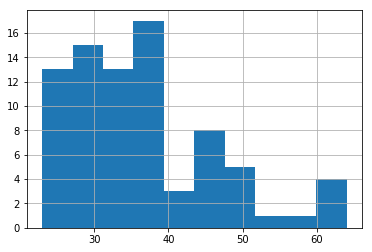

In [286]:
round1_subj_info['age'].hist()

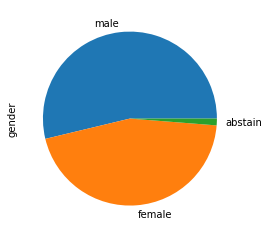

In [287]:
round1_subj_info['gender'].value_counts().plot.pie(figsize=(4,4))

In [288]:
round1_subj_info['education'].value_counts()

graduated_college        41
graduated_high_school    26
higher_degree            11
other                     1
abstain                   1
Name: education, dtype: int64

In [289]:
round1_subj_info['party'].value_counts()

democrat       38
independent    24
republican     12
abstain         4
other           2
Name: party, dtype: int64

In [290]:
round1_subj_info['party'].value_counts()/len(round1_subj_info)

democrat       0.475
independent    0.300
republican     0.150
abstain        0.050
other          0.025
Name: party, dtype: float64

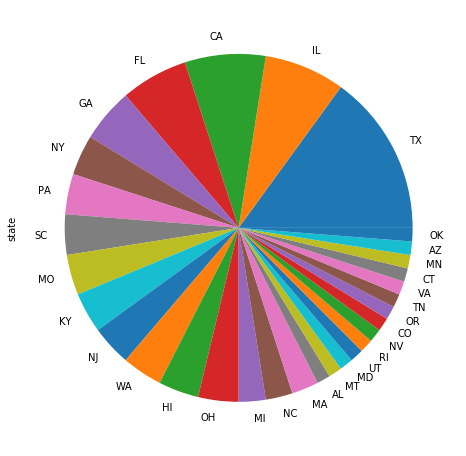

In [291]:
round1_subj_info['state'].value_counts().plot.pie(figsize=(8,8))

### Round 2

In [292]:
round2_subj_info = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == 2]

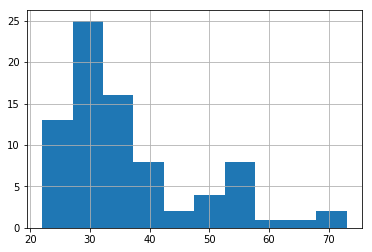

In [293]:
round2_subj_info['age'].hist()

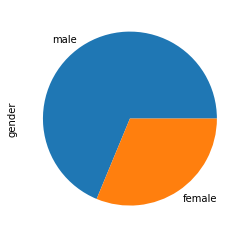

In [294]:
round2_subj_info['gender'].value_counts().plot.pie(figsize=(4,4))

In [295]:
round2_subj_info['education'].value_counts()

graduated_college        48
graduated_high_school    23
higher_degree             8
other                     1
Name: education, dtype: int64

In [296]:
round2_subj_info['party'].value_counts()

democrat       35
independent    22
republican     19
other           3
abstain         1
Name: party, dtype: int64

In [297]:
round2_subj_info['party'].value_counts()/len(round2_subj_info)

democrat       0.4375
independent    0.2750
republican     0.2375
other          0.0375
abstain        0.0125
Name: party, dtype: float64

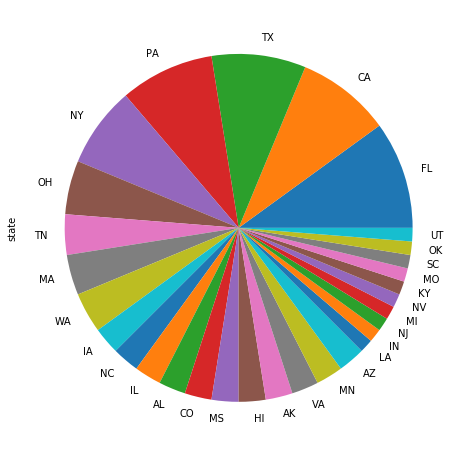

In [298]:
round2_subj_info['state'].value_counts().plot.pie(figsize=(8,8))

### Round 3

In [277]:
round3_subj_info = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == 3]

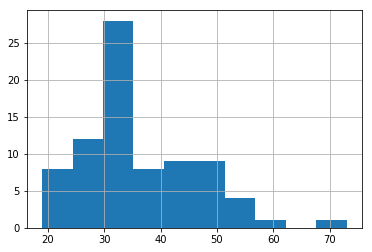

In [279]:
round3_subj_info['age'].hist()

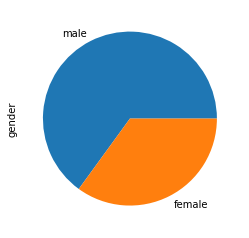

In [280]:
round3_subj_info['gender'].value_counts().plot.pie(figsize=(4,4))

In [281]:
round3_subj_info['education'].value_counts()

graduated_college        36
graduated_high_school    33
higher_degree            10
other                     1
Name: education, dtype: int64

In [282]:
round3_subj_info['party'].value_counts()

democrat       37
independent    26
republican     15
other           1
abstain         1
Name: party, dtype: int64

In [283]:
round3_subj_info['party'].value_counts()/len(round3_subj_info)

democrat       0.4625
independent    0.3250
republican     0.1875
other          0.0125
abstain        0.0125
Name: party, dtype: float64

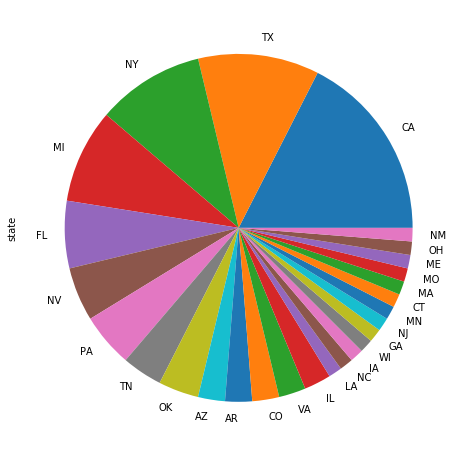

In [284]:
round3_subj_info['state'].value_counts().plot.pie(figsize=(8,8))

### Round 4

In [18]:
round4_subj_info = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == 4]

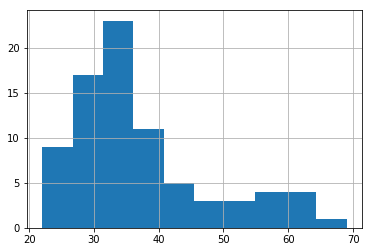

In [19]:
round4_subj_info['age'].hist()

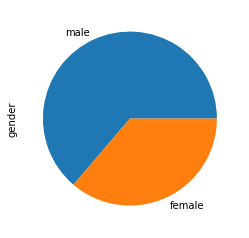

In [20]:
round4_subj_info['gender'].value_counts().plot.pie(figsize=(4,4))

In [22]:
round4_subj_info['education'].value_counts()

graduated_college        44
graduated_high_school    21
higher_degree            13
other                     2
Name: education, dtype: int64

In [24]:
round4_subj_info['party'].value_counts()

democrat       37
independent    24
republican     19
Name: party, dtype: int64

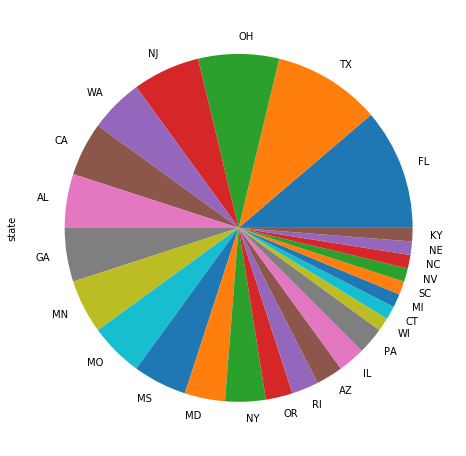

In [26]:
round4_subj_info['state'].value_counts().plot.pie(figsize=(8,8))

### Round 5

In [16]:
round5_subj_info = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == 5]

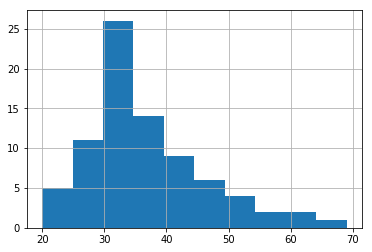

In [17]:
round5_subj_info['age'].hist()

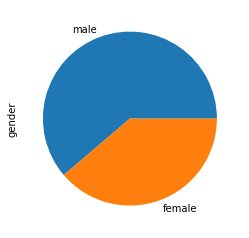

In [18]:
round5_subj_info['gender'].value_counts().plot.pie(figsize=(4,4))

In [19]:
round5_subj_info['education'].value_counts()

graduated_college        36
graduated_high_school    21
higher_degree            19
other                     3
abstain                   1
Name: education, dtype: int64

In [20]:
round5_subj_info['party'].value_counts()

democrat       37
republican     20
independent    19
other           3
abstain         1
Name: party, dtype: int64

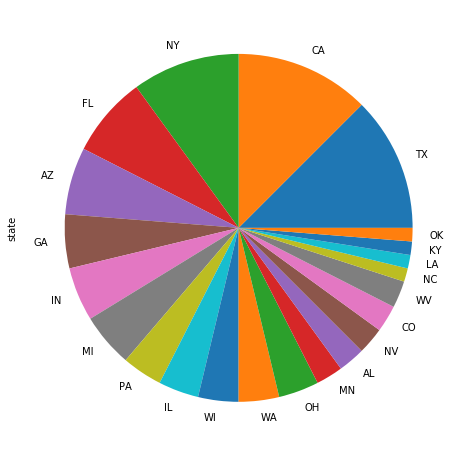

In [21]:
round5_subj_info['state'].value_counts().plot.pie(figsize=(8,8))

## On aggregate

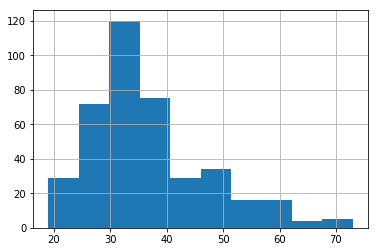

In [22]:
SUBJ_INFO_ALL_ROUNDS['age'].hist()

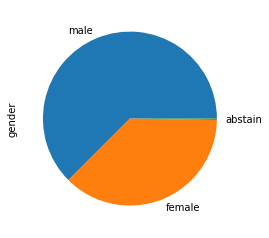

In [23]:
SUBJ_INFO_ALL_ROUNDS['gender'].value_counts().plot.pie(figsize=(4,4))

In [24]:
SUBJ_INFO_ALL_ROUNDS['education'].value_counts()

graduated_college        205
graduated_high_school    124
higher_degree             61
other                      8
abstain                    2
Name: education, dtype: int64

In [25]:
SUBJ_INFO_ALL_ROUNDS['party'].value_counts()

democrat       184
independent    115
republican      85
other            9
abstain          7
Name: party, dtype: int64

In [26]:
SUBJ_INFO_ALL_ROUNDS['party'].value_counts()/len(SUBJ_INFO_ALL_ROUNDS)

democrat       0.4600
independent    0.2875
republican     0.2125
other          0.0225
abstain        0.0175
Name: party, dtype: float64

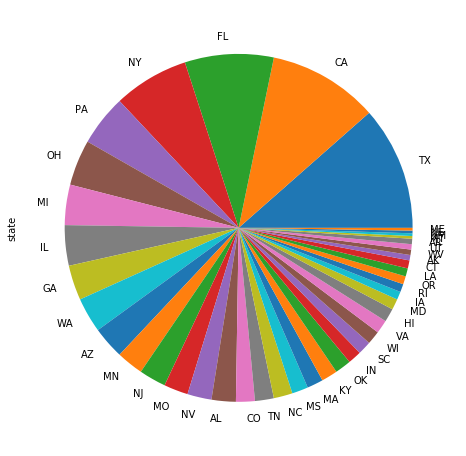

In [27]:
SUBJ_INFO_ALL_ROUNDS['state'].value_counts().plot.pie(figsize=(8,8))

# Examine RTs

In [28]:
RT_dict = {}
for ROUND_NO in range(1,1+N_ROUNDS):
    RTs_per_batch = {}
    subj_info = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == ROUND_NO]
    for BATCH_NO in BATCH_NOS:
        RTs = subj_info[subj_info['batch'] == BATCH_NO]['timeSpent'] 
        RTs_per_batch[BATCH_NO] = {'mean':RTs.mean(),
                                  'max':RTs.max(),
                                  'min':RTs.min()}
    RT_dict[ROUND_NO] = RTs_per_batch

In [29]:
pd.DataFrame(RT_dict[5]) # Mean, max, and min RTs per batch from round 5

,0,1,2,3,4,5,6,7,8,9
mean,17.298892,10.501683,22.168817,17.563727,15.990825,14.602825,16.025790,12.801813,13.313031,17.555302
max,39.870800,18.667283,33.094500,39.802233,28.889833,22.796300,30.807150,19.812267,21.708033,28.044117
min,8.761383,6.047633,11.361783,6.301750,7.364467,8.197317,6.500583,7.256400,6.938100,7.217467


Overall average reading time:

In [30]:
pd.concat([pd.DataFrame(RT_dict[ROUND_NO]) for ROUND_NO in range(1,1+N_ROUNDS)],axis=1).loc['mean'].mean()

13.409723499999998

# Examine responses to poll Qs

In [31]:
POLL_QS = ['Do you think that the world’s temperature has been going up over the past 100 years,\
or do you think this has not been happening?',
          'How sure are you that the world’s temperature has {{ negation }} been going up over the past\
          100 years?',
          'Do you think that changes in the world’s temperature over the past 100 years have been caused mostly by things people have done, mostly by natural causes,\
          or about equally by things people have done and by natural causes?',
          'In your opinion, do you think the federal government should or should not limit the\
amount of greenhouse gases that U.S. businesses put out?',
          'How concerned are you about global warming?',
          'During the past 6 months, how often did you hear about global warming in the media?',
          'How accurately do you think the news media reports on global warming?']

In [32]:
all_poll_dfs = {}
for ROUND_NO in range(1,1+N_ROUNDS):
    poll_dfs = {}
    subj_info = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == ROUND_NO]
    for BATCH_NO in BATCH_NOS:
        poll_df = subj_info[subj_info['batch'] == BATCH_NO][['poll{}'.format(ix) for ix in range(1,8)]].T
        poll_df['statement'] = POLL_QS
        poll_df = poll_df.append(pd.DataFrame(subj_info[subj_info['batch'] == BATCH_NO]['party']).T)
        poll_dfs[BATCH_NO] = poll_df
    all_poll_dfs[ROUND_NO] = poll_dfs

In [33]:
all_poll_dfs[5][9] # Poll responses from round 4, batch 10

,392,393,394,395,396,397,398,399,statement
poll1,indeed,not,indeed,indeed,indeed,indeed,indeed,indeed,Do you think that the world’s temperature has ...
poll2,very,very,very,moderately,very,very,very,very,How sure are you that the world’s temperature ...
poll3,both,natural,people,both,people,both,people,people,Do you think that changes in the world’s tempe...
poll4,yes,yes,yes,yes,yes,yes,yes,yes,"In your opinion, do you think the federal gove..."
poll5,somewhat,extremely,extremely,somewhat,very,very,extremely,moderately,How concerned are you about global warming?
poll6,weekly,weekly,monthly,many_weekly,many_weekly,weekly,many_weekly,monthly,"During the past 6 months, how often did you he..."
poll7,not,very,very,not,very,very,very,moderately,How accurately do you think the news media rep...
party,democrat,democrat,democrat,republican,democrat,republican,democrat,independent,NaN


# Format trial data

In [43]:
worker_labels_per_round = {}

In [44]:
for ROUND_NO in range(1,1+N_ROUNDS):
    trial_info = pickle.load(open('round{}_trial_infos.pkl'.format(ROUND_NO),'rb'))
    trials_per_worker = {BATCH_NO: trial_info[BATCH_NO].groupby('workerid') 
                    for BATCH_NO in BATCH_NOS}
    
    worker_annotations = {}
    for BATCH_NO in BATCH_NOS:
        labels_per_worker = {}
        for w_id in trials_per_worker[BATCH_NO].first().index:
            worker_labels = trials_per_worker[BATCH_NO].get_group(w_id).sort_values(by='trial_sent_id')
            worker_labels = worker_labels.set_index('trial_sent_id')
            worker_labels = worker_labels[['option_chosen']]
            #print(worker_labels)
            worker_labels.columns = ['worker_{}'.format(w_id)]
            labels_per_worker[w_id] = worker_labels
        worker_annotations[BATCH_NO] = labels_per_worker
        
    worker_labels_per_batch = {}
    for BATCH_NO in BATCH_NOS:
        all_worker_labels = pd.concat([worker_annotations[BATCH_NO][w_id] for w_id in range(0,8)], axis=1)
        worker_labels_per_batch[BATCH_NO] = all_worker_labels
    #print(worker_labels_per_batch[0])
        
    for BATCH_NO in BATCH_NOS:
        worker_labels_per_batch[BATCH_NO]['sentence'] = [pd.DataFrame(ROUND_DATA[ROUND_NO][BATCH_NO])\
                                                         .set_index('sent_id')\
                                                         .loc[s_id]['sentence'] for s_id in 
                                                         worker_labels_per_batch[BATCH_NO].index]
        worker_labels_per_batch[BATCH_NO]['av_rating'] = [np.average(
        [label2int[worker_labels_per_batch[BATCH_NO]['worker_{}'.format(w_id)].loc[sent_id]]
         for w_id in range(0,8)]) for sent_id in worker_labels_per_batch[BATCH_NO].index]
    
    worker_labels_per_round[ROUND_NO] = worker_labels_per_batch

In [109]:
worker_labels_per_round[5][9] # labels for each sentence from round 2, batch 10

,MACE_pred,av_rating,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7
s0,disagrees,-1.000,Global warming is a hoax.,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees
s1,agrees,0.875,Alarming levels of sea level rise are predicte...,neutral,agrees,agrees,agrees,agrees,agrees,agrees,agrees
s2,neutral,0.250,"Over the past several years, the United States...",neutral,agrees,neutral,neutral,neutral,neutral,agrees,neutral
s3,agrees,0.750,Global warming is happening and it will be dan...,agrees,disagrees,agrees,agrees,agrees,agrees,agrees,agrees
s4,neutral,0.000,Some icebergs are cute.,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
t0,agrees,0.625,Mr. Steyer top priorities are addressing clima...,neutral,agrees,neutral,neutral,agrees,agrees,agrees,agrees
t1,neutral,0.125,"Mr. Trump, who has mocked climate science as a...",neutral,neutral,neutral,neutral,agrees,neutral,disagrees,agrees
t10,agrees,0.625,I'm proud to stand with young people in Iowa a...,agrees,disagrees,agrees,agrees,agrees,neutral,agrees,agrees
t11,neutral,0.000,Even insurers are struggling to predict the ri...,neutral,disagrees,neutral,neutral,neutral,agrees,agrees,disagrees
t12,neutral,0.500,We are celebrating an agreement where the worl...,neutral,agrees,agrees,neutral,agrees,neutral,agrees,neutral


In [110]:
pickle.dump(worker_labels_per_round,open('full_ratings_per_round.pkl','wb'))

# Generate MACE scores

Write output for MACE:

In [37]:
for ROUND_NO in range(5,1+N_ROUNDS):
    for BATCH_NO in BATCH_NOS:
        MACE_df = worker_labels_per_round[ROUND_NO][BATCH_NO].drop(['sentence','av_rating'],axis=1)
        MACE_df = MACE_df.reset_index(drop=True)
        MACE_df.to_csv('round{}_batch{}_data_MACE.csv'.format(ROUND_NO,BATCH_NO),header=None,index=False)

Run MACE from command line.

Yiweis-new-MacBook-Air:MACE yiweiluo$ java -jar MACE.jar --prefix round5_batch0 /Users/yiweiluo/scientific-debates/cc_stance/MTurk_results/round5_batch0_data_MACE.csv''

Read back in the MACE scores.

In [45]:
all_worker_competences = []
for ROUND_NO in range(1,1+N_ROUNDS):
    for BATCH_NO in BATCH_NOS:
        #print('============ Batch #{} ============'.format(BATCH_NO))
        MACE_preds = []
        worker_competences = []
        with open('/Users/yiweiluo/MACE/round{}_batch{}.prediction'.format(ROUND_NO,BATCH_NO),'r') as f:
            for line in f:
                MACE_preds.append(line.strip())
        with open('/Users/yiweiluo/MACE/round{}_batch{}.competence'.format(ROUND_NO,BATCH_NO),'r') as f:
            worker_competences = f.readlines()[0].strip().split('\t')
        worker_competences = [float(c) for c in worker_competences]
        #print(MACE_preds)
        #print(worker_competences)
        all_worker_competences.extend(worker_competences)
        worker_labels_per_round[ROUND_NO][BATCH_NO]['MACE_pred'] = MACE_preds
        comp_df = pd.DataFrame(worker_competences)
        comp_df.index = ['worker_{}'.format(w_id) for w_id in range(0,8)]
        comp_df = comp_df.T
        comp_df.index = ['MACE competence']
        worker_labels_per_round[ROUND_NO][BATCH_NO] = worker_labels_per_round[ROUND_NO][BATCH_NO].append(comp_df)
        #print('\n')

(array([ 33.,   7.,   5.,  18.,  39.,  56.,  82., 102.,  49.,   9.]),
 array([0.00475038, 0.10216977, 0.19958915, 0.29700854, 0.39442793,
        0.49184731, 0.5892667 , 0.68668609, 0.78410547, 0.88152486,
        0.97894425]),
 <a list of 10 Patch objects>)

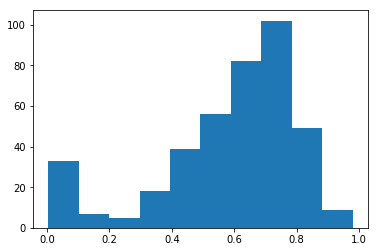

In [46]:
plt.hist(all_worker_competences)

# IAA

Overall distribution of labels per round, excluding output from low MACE raters. There appears to be a slight skew to sentences rated as "agrees".

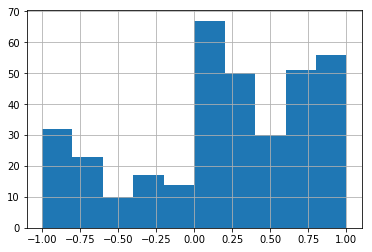

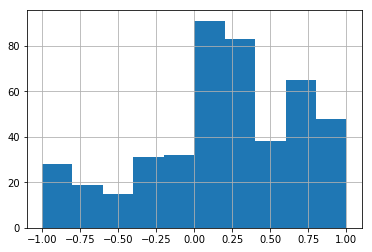

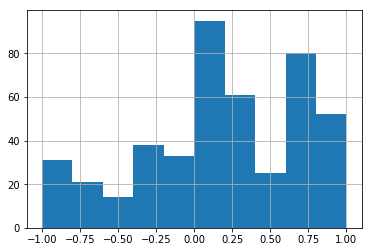

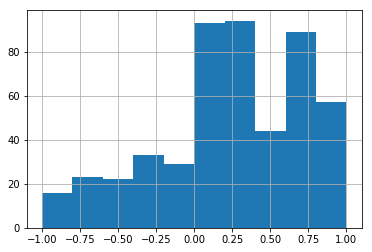

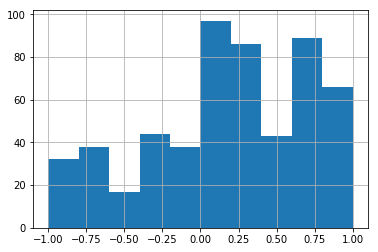

In [47]:
for ROUND_NO in range(1,1+N_ROUNDS):
    plt.figure()
    hist = pd.concat([worker_labels_per_round[ROUND_NO][BATCH_NO]['av_rating']\
           .drop('MACE competence') for BATCH_NO in BATCH_NOS]).hist()

On aggregate:

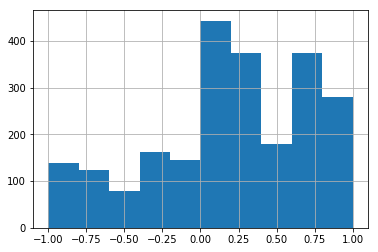

In [48]:
pd.concat([worker_labels_per_round[ROUND_NO][BATCH_NO]['av_rating']\
           .drop('MACE competence') for BATCH_NO in BATCH_NOS for ROUND_NO in range(1,1+N_ROUNDS)]).hist()

In [49]:
IAA_dict = {}

In [50]:
for ROUND_NO in range(1,1+N_ROUNDS):
    trial_info = pickle.load(open('round{}_trial_infos.pkl'.format(ROUND_NO),'rb'))
    trials_per_worker = {BATCH_NO: trial_info[BATCH_NO].groupby('workerid') 
                    for BATCH_NO in BATCH_NOS}
    
    MACE_below_count = 0
    av_alpha_non_screen = 0
    av_alpha_non_screen_high_MACE = 0
    for BATCH_NO in BATCH_NOS:
        #print('============ Batch #{} ============'.format(BATCH_NO))
        data_per_coder = []
        for w_id in trials_per_worker[BATCH_NO].first().index:
            worker_data_dict = {sent_index: label2int[worker_labels_per_round[ROUND_NO][BATCH_NO]['worker_{}'\
                                                                                                  .format(w_id)].\
                                                      loc[sent_index]] 
                            for sent_index in worker_labels_per_round[ROUND_NO][BATCH_NO].index 
                                if sent_index[0] == 's'}
            data_per_coder.append(worker_data_dict)
        #print('Krippendorff alpha on screen questions:',krippendorff_alpha(data_per_coder))
        data_per_coder = []
        for w_id in trials_per_worker[BATCH_NO].first().index:
            worker_data_dict = {sent_index: label2int[worker_labels_per_round[ROUND_NO][BATCH_NO]['worker_{}'\
                                                                                                  .format(w_id)].\
                                                      loc[sent_index]] 
                            for sent_index in worker_labels_per_round[ROUND_NO][BATCH_NO].index 
                                if sent_index[0] == 't'}
            data_per_coder.append(worker_data_dict)
        #print('Krippendorff alpha on true questions:',krippendorff_alpha(data_per_coder))
        av_alpha_non_screen += krippendorff_alpha(data_per_coder)
        data_per_coder = []
        for w_id in trials_per_worker[BATCH_NO].first().index:
            if worker_labels_per_round[ROUND_NO][BATCH_NO].loc['MACE competence']['worker_{}'.format(w_id)] > 0.4:
                worker_data_dict = {sent_index: label2int[worker_labels_per_round[ROUND_NO][BATCH_NO]\
                                                          ['worker_{}'.format(w_id)].\
                                                          loc[sent_index]] 
                                for sent_index in worker_labels_per_round[ROUND_NO][BATCH_NO].index 
                                    if sent_index[0] == 't'}
                data_per_coder.append(worker_data_dict)
            else:
                MACE_below_count += 1
        #print('Krippendorff alpha on true questions, MACE > 0.4:',krippendorff_alpha(data_per_coder))
        av_alpha_non_screen_high_MACE += krippendorff_alpha(data_per_coder)
        #print('\n')
    IAA_dict[ROUND_NO] = {'low MACE N':MACE_below_count,
                         'alpha all':av_alpha_non_screen/10.,
                         'alpha high MACE':av_alpha_non_screen_high_MACE/10.}

In [51]:
pd.DataFrame(IAA_dict) # Results for each round

,1,2,3,4,5
low MACE N,9.000000,14.000000,9.000000,17.000000,16.000000
alpha all,0.549561,0.420787,0.485673,0.356296,0.391512
alpha high MACE,0.635210,0.541162,0.559662,0.546450,0.600750


# Analysis

## Effect size of party on each of the poll questions

In [54]:
def poll14_to_int(x):
    if x == 'indeed' or x == 'yes':
        return 0
    else:
        return 1
def poll3_to_int(x):
    if x == 'people':
        return 0
    elif x == 'both':
        return 1
    else:
        return 2

In [55]:
def poll2567_to_int(x):
    if x == 'extremely' or x == 'many_weekly':
        return 0
    elif x == 'very' or x == 'weekly':
        return 1
    elif x == 'moderately' or x == 'monthly':
        return 2
    elif x == 'somewhat' or x == 'year':
        return 3
    else:
        return 4

In [56]:
PARTIES = ['republican','democrat','independent','other','abstain']

In [57]:
poll_resps = {poll_no: {party:[] for party in ['republican','democrat','independent','other','abstain']}
             for poll_no in range(1,8)}

In [58]:
# populate poll responses over all 10 batches
for poll_no in range(1,8):
    for round_no in range(1,5):
        for batch_no in BATCH_NOS:
            subj_info = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == round_no]\
[SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == round_no]['batch'] == batch_no]
            parties = subj_info['party']
            polls = subj_info['poll{}'.format(poll_no)]
            if poll_no == 1 or poll_no == 4:
                num_answers = polls.apply(poll14_to_int)
            elif poll_no == 3:
                num_answers = polls.apply(poll3_to_int)
            else:
                num_answers = polls.apply(poll2567_to_int)
            for ix in range(8):
                party = parties.iloc[ix]
                poll_ans = num_answers.iloc[ix]
                poll_resps[poll_no][party].append(poll_ans)

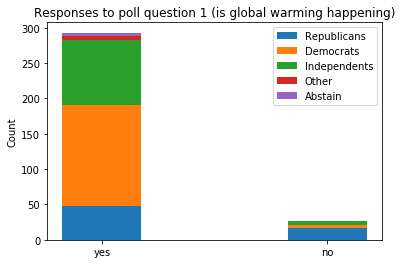

In [98]:
partyCounts = {party: [len([x for x in poll_resps[1][party] if x == 0]),
                      len([x for x in poll_resps[1][party] if x == 1])] for party in PARTIES}
p1 = plt.bar(['yes','no'],partyCounts['republican'],width = 0.35)
p2 = plt.bar(['yes','no'],partyCounts['democrat'],bottom=partyCounts['republican'],width = 0.35)
p3 = plt.bar(['yes','no'],partyCounts['independent'],
             bottom=np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),width = 0.35)
p4 = plt.bar(['yes','no'],partyCounts['other'],
             bottom=np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).tolist(),
             width = 0.35)
p5 = plt.bar(['yes','no'],partyCounts['abstain'],
             bottom=np.add(np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).\
       tolist(),partyCounts['other']).tolist(),width = 0.35)
plt.ylabel('Count')
plt.title("Responses to poll question 1 (is global warming happening)")
plt.xticks(np.arange(2), ('yes','no'))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Republicans', 'Democrats', 'Independents', 'Other','Abstain'))
plt.show()

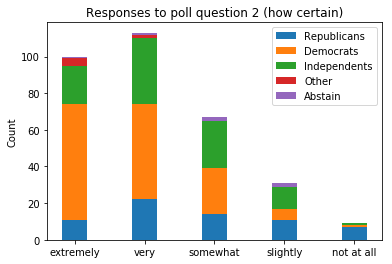

In [97]:
partyCounts = {party: [len([x for x in poll_resps[2][party] if x == option]) for option in range(5)] 
               for party in PARTIES}
answers = ['extremely','very','somewhat','slightly','not at all']
p1 = plt.bar(answers,partyCounts['republican'],width = 0.35)
p2 = plt.bar(answers,partyCounts['democrat'],bottom=partyCounts['republican'],width = 0.35)
p3 = plt.bar(answers,partyCounts['independent'],
             bottom=np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),width = 0.35)
p4 = plt.bar(answers,partyCounts['other'],
             bottom=np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).tolist(),
             width = 0.35)
p5 = plt.bar(answers,partyCounts['abstain'],
             bottom=np.add(np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).\
       tolist(),partyCounts['other']).tolist(),width = 0.35)
plt.ylabel('Count')
plt.title("Responses to poll question 2 (how certain)")
plt.xticks(np.arange(5), ('extremely','very','somewhat','slightly','not at all'))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Republicans', 'Democrats', 'Independents', 'Other','Abstain'))
plt.show()

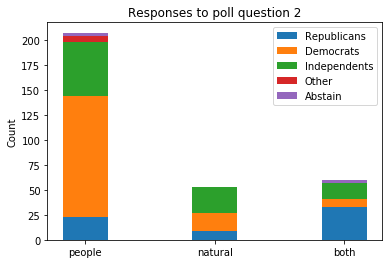

In [92]:
partyCounts = {party: [len([x for x in poll_resps[3][party] if x == option]) for option in range(3)] 
               for party in PARTIES}
answers = ['people','natural','both']
p1 = plt.bar(answers,partyCounts['republican'],width = 0.35)
p2 = plt.bar(answers,partyCounts['democrat'],bottom=partyCounts['republican'],width = 0.35)
p3 = plt.bar(answers,partyCounts['independent'],
             bottom=np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),width = 0.35)
p4 = plt.bar(answers,partyCounts['other'],
             bottom=np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).tolist(),
             width = 0.35)
p5 = plt.bar(answers,partyCounts['abstain'],
             bottom=np.add(np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).\
       tolist(),partyCounts['other']).tolist(),width = 0.35)
plt.ylabel('Count')
plt.title("Responses to poll question 2")
plt.xticks(np.arange(len(answers)), answers)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Republicans', 'Democrats', 'Independents', 'Other','Abstain'))
plt.show()

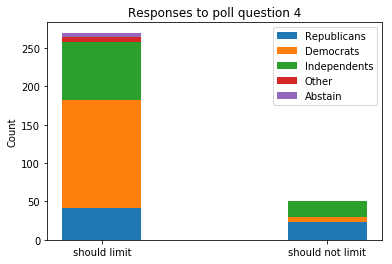

In [93]:
partyCounts = {party: [len([x for x in poll_resps[4][party] if x == option]) for option in range(2)] 
               for party in PARTIES}
answers = ['should limit','should not limit']
p1 = plt.bar(answers,partyCounts['republican'],width = 0.35)
p2 = plt.bar(answers,partyCounts['democrat'],bottom=partyCounts['republican'],width = 0.35)
p3 = plt.bar(answers,partyCounts['independent'],
             bottom=np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),width = 0.35)
p4 = plt.bar(answers,partyCounts['other'],
             bottom=np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).tolist(),
             width = 0.35)
p5 = plt.bar(answers,partyCounts['abstain'],
             bottom=np.add(np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).\
       tolist(),partyCounts['other']).tolist(),width = 0.35)
plt.ylabel('Count')
plt.title("Responses to poll question 4")
plt.xticks(np.arange(len(answers)), answers)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Republicans', 'Democrats', 'Independents', 'Other','Abstain'))
plt.show()

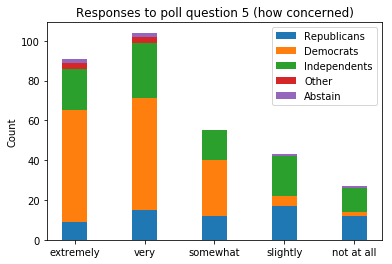

In [94]:
partyCounts = {party: [len([x for x in poll_resps[5][party] if x == option]) for option in range(5)] 
               for party in PARTIES}
answers = ['extremely','very','somewhat','slightly','not at all']
p1 = plt.bar(answers,partyCounts['republican'],width = 0.35)
p2 = plt.bar(answers,partyCounts['democrat'],bottom=partyCounts['republican'],width = 0.35)
p3 = plt.bar(answers,partyCounts['independent'],
             bottom=np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),width = 0.35)
p4 = plt.bar(answers,partyCounts['other'],
             bottom=np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).tolist(),
             width = 0.35)
p5 = plt.bar(answers,partyCounts['abstain'],
             bottom=np.add(np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).\
       tolist(),partyCounts['other']).tolist(),width = 0.35)
plt.ylabel('Count')
plt.title("Responses to poll question 5 (how concerned)")
plt.xticks(np.arange(len(answers)), answers)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Republicans', 'Democrats', 'Independents', 'Other','Abstain'))
plt.show()

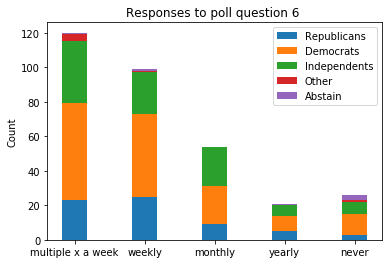

In [95]:
partyCounts = {party: [len([x for x in poll_resps[6][party] if x == option]) for option in range(5)] 
               for party in PARTIES}
answers = ['multiple x a week','weekly','monthly','yearly','never']
p1 = plt.bar(answers,partyCounts['republican'],width = 0.35)
p2 = plt.bar(answers,partyCounts['democrat'],bottom=partyCounts['republican'],width = 0.35)
p3 = plt.bar(answers,partyCounts['independent'],
             bottom=np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),width = 0.35)
p4 = plt.bar(answers,partyCounts['other'],
             bottom=np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).tolist(),
             width = 0.35)
p5 = plt.bar(answers,partyCounts['abstain'],
             bottom=np.add(np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).\
       tolist(),partyCounts['other']).tolist(),width = 0.35)
plt.ylabel('Count')
plt.title("Responses to poll question 6 ")
plt.xticks(np.arange(len(answers)), answers)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Republicans', 'Democrats', 'Independents', 'Other','Abstain'))
plt.show()

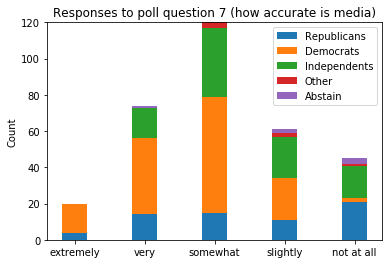

In [96]:
partyCounts = {party: [len([x for x in poll_resps[7][party] if x == option]) for option in range(5)] 
               for party in PARTIES}
answers = ['extremely','very','somewhat','slightly','not at all']
p1 = plt.bar(answers,partyCounts['republican'],width = 0.35)
p2 = plt.bar(answers,partyCounts['democrat'],bottom=partyCounts['republican'],width = 0.35)
p3 = plt.bar(answers,partyCounts['independent'],
             bottom=np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),width = 0.35)
p4 = plt.bar(answers,partyCounts['other'],
             bottom=np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).tolist(),
             width = 0.35)
p5 = plt.bar(answers,partyCounts['abstain'],
             bottom=np.add(np.add(np.add(partyCounts['republican'], partyCounts['democrat']).tolist(),partyCounts['independent']).\
       tolist(),partyCounts['other']).tolist(),width = 0.35)
plt.ylabel('Count')
plt.title("Responses to poll question 7 (how accurate is media)")
plt.xticks(np.arange(len(answers)), answers)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Republicans', 'Democrats', 'Independents', 'Other','Abstain'))
plt.show()

In [79]:
for poll_no in range(1,8):
    for ix_party_1 in range(len(PARTIES)-1):
        for ix_party_2 in range(ix_party_1+1,len(PARTIES)):
            #print(poll_resps[poll_no][PARTIES[ix_party_1]])
            #print(poll_resps[PARTIES[ix_party_2]])
            ttest_res = stats.ttest_ind(poll_resps[poll_no][PARTIES[ix_party_1]],poll_resps[poll_no][PARTIES[ix_party_2]])
            if ttest_res[1] <= 0.05:
                print('T-test of means in Poll {} response b/w {}s and {}s'.format(poll_no,
                                                                                   PARTIES[ix_party_1],
                                                                                   PARTIES[ix_party_2]))
                print(ttest_res)
                print('\n')
            #except KeyError:
                
                #print('{}s and {}s are not both found in this batch'.format(PARTIES[ix_party_1],
                 #                                                          PARTIES[ix_party_2]))

T-test of means in Poll 1 response b/w republicans and democrats
Ttest_indResult(statistic=6.491623349521909, pvalue=4.2790252548154864e-10)


T-test of means in Poll 1 response b/w republicans and independents
Ttest_indResult(statistic=4.604302767612731, pvalue=7.452607234954543e-06)


T-test of means in Poll 1 response b/w democrats and abstains
Ttest_indResult(statistic=-2.634891637190082, pvalue=0.009099957448829701)


T-test of means in Poll 2 response b/w republicans and democrats
Ttest_indResult(statistic=5.709149710130504, pvalue=3.840616191101495e-08)


T-test of means in Poll 2 response b/w republicans and independents
Ttest_indResult(statistic=2.1165852115734625, pvalue=0.035851746032549106)


T-test of means in Poll 2 response b/w republicans and others
Ttest_indResult(statistic=2.6652735238030956, pvalue=0.00957177020048261)


T-test of means in Poll 2 response b/w democrats and independents
Ttest_indResult(statistic=-3.991598122923215, pvalue=8.714965055427861e-05)


T-te

In [ ]:
# No significant difference for Round 3 b/w parties on P1 and P6!

## Does item length bias rating?

In [441]:
# Find entropy over different answers for each item, see if on average over all items in all batches, 
# longer items have larger entropy?

In [80]:
entropies_per_sent = {}
for ROUND_NO in range(1,5):
    for BATCH_NO in BATCH_NOS:
        for s_id in worker_labels_per_round[ROUND_NO][BATCH_NO].drop('MACE competence').index[5:]: # ignore screen
            sent = worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id]['sentence']
            # tokenize on white-space
            #sent_len = len(sent.split())
            ratings = worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id]\
            [['worker_{}'.format(w_id) for w_id in range(8)]]
            rating_counts = ratings.value_counts()
            for ans in ['agrees','neutral','disagrees']:
                if ans in rating_counts:
                    continue
                else:
                    rating_counts[ans] = 0
            ps = [rating_counts[x]*1./rating_counts.sum() for x in ['disagrees','agrees','neutral']]
            entropy = stats.entropy(ps)
            entropies_per_sent[sent] = entropy

In [93]:
ratings

worker_0    neutral
worker_1     agrees
worker_2     agrees
worker_3     agrees
worker_4    neutral
worker_5     agrees
worker_6     agrees
worker_7    neutral
Name: t9, dtype: object

In [94]:
rating_counts

agrees       5
neutral      3
disagrees    0
Name: t9, dtype: int64

In [95]:
ps

[0.0, 0.625, 0.375]

In [96]:
stats.entropy(ps)

0.6615632381579821

In [88]:
sorted_entropies_per_sent = sorted(entropies_per_sent.items(), key=lambda x:x[1])

In [91]:
sorted_entropies_per_sent[-30:]

[('The global warming of the 1900s is caused by a rise in solar output.',
  1.0821955300387671),
 ('The findings do not undermine global warming theory.', 1.0821955300387671),
 ('The fifteen-year long “ global warming ” campaign all along meant “ climate change ” and that this in turn means that places supposed to get hotter get hotter and that places that are supposed to get colder — under global warming, er, climate change — get colder.',
  1.0821955300387671),
 ('Sea level rise in the 20th century is mostly man-made.',
  1.0821955300387671),
 ('It gives us a dangerous climate that we make safe, above all, by using energy from fossil fuels.',
  1.0821955300387671),
 ('Global warning will be overridden by this effect, giving humankind and the Earth 30 years to sort out our pollution.',
  1.0821955300387671),
 ('Global warming has slowed because of measures taken by the government.',
  1.0821955300387671),
 ('Carbon dioxide is a perfectly natural gas.', 1.0821955300387671),
 ('The glob

In [81]:
stats.pearsonr([len(key.split()) for key in entropies_per_sent],
               [entropies_per_sent[key] for key in entropies_per_sent])

(0.04810238561398431, 0.058964128886909654)

In [82]:
stats.spearmanr([len(key.split()) for key in entropies_per_sent],
               [entropies_per_sent[key] for key in entropies_per_sent])

SpearmanrResult(correlation=0.06127534145987844, pvalue=0.016106680177920305)

(array([201.,   0.,   0., 302.,   0., 269., 447.,   0., 137., 186.]),
 array([0.        , 0.10821955, 0.21643911, 0.32465866, 0.43287821,
        0.54109777, 0.64931732, 0.75753687, 0.86575642, 0.97397598,
        1.08219553]),
 <a list of 10 Patch objects>)

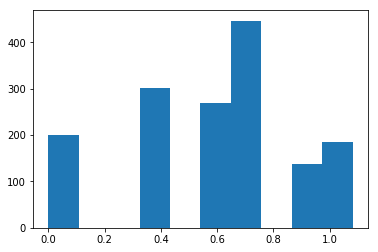

In [92]:
plt.hist(entropies_per_sent.values(),bins=10)

## Does original source media slant bias rating? 

In [102]:
data_for_mturk = pd.read_pickle('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/data_for_mturk.pkl')

In [150]:
data_for_mturk

,subject,negation,verb,comp_clause,sent_key,bias,pretty_clause
0,I,None,think,there is a danger that we can get used to glob...,sent_no_37 of http://dotearth.blogs.nytimes.co...,pro,There is a danger that we can get used to glob...
1,implication,None,is,that if global warming proceeds slowly enough ...,sent_no_49 of http://dotearth.blogs.nytimes.co...,pro,"If global warming proceeds slowly enough, then..."
2,head,None,asserted,that global warming was behind unusual atmosph...,sent_no_7 of http://dotearth.blogs.nytimes.com...,pro,Global warming is behind unusual atmospheric p...
3,I,None,thought,the global situation worth a look at the map a...,sent_no_5 of http://dotearth.blogs.nytimes.com...,pro,The global situation worth a look at the map a...
4,Dr. Betts,None,stressed,that there was a definite declining trend in A...,sent_no_13 of http://dotearth.blogs.nytimes.co...,pro,There is a definite declining trend in Arctic ...
...,...,...,...,...,...,...,...
19000,Ebell,None,emphasized,The U.S. going back to the stone age will not ...,sent_no_53 of https://pjmedia.com/trending/eco...,anti,The U.S. going back to the stone age will not ...
19001,Amy Klobuchar,None,announced,"that Amy Klobuchar is running for President , ...",sent_no_6 of https://pjmedia.com/video/amy-klo...,anti,"Amy Klobuchar is running for President, talkin..."
19002,Amy Klobuchar,None,announced,"that Amy Klobuchar is running for President , ...",sent_no_9 of https://pjmedia.com/video/amy-klo...,anti,"Amy Klobuchar is running for President, talkin..."
19003,failure,None,demonstrate,just how vacuous the global warming narrative ...,sent_no_36 of https://pjmedia.com/video/amy-kl...,anti,Just how vacuous the global warming narrative ...


In [151]:
ROUND_sent_id_df

,sentence,option1,option2,option3,condition,df_key
sent_id,,,,,,
s0,Global warming is a hoax.,agrees,disagrees,neutral,screen,-1
s1,Alarming levels of sea level rise are predicte...,agrees,disagrees,neutral,screen,-1
s2,"Over the past several years, the United States...",agrees,disagrees,neutral,screen,-1
s3,Global warming is happening and it will be dan...,agrees,disagrees,neutral,screen,-1
s4,Some icebergs are cute.,agrees,disagrees,neutral,screen,-1
t0,Every corner of the United States is being hit...,agrees,disagrees,neutral,true,1614
t1,Recent hurricane activity had not been made mo...,agrees,disagrees,neutral,true,16628
t2,"The presence of Mr. Pruitt, who says he does n...",agrees,disagrees,neutral,true,2168
t3,As global warming is melting the ice cover and...,agrees,disagrees,neutral,true,18530


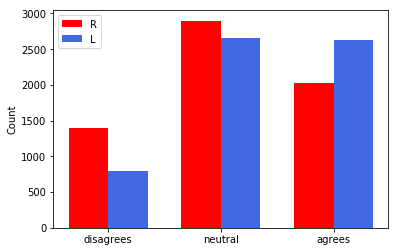

In [170]:
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, [1396,2899,2025], width, color='red')
rects2 = ax.bar(ind+width, [789,2663,2628], width, color='royalblue')

# add some
ax.set_ylabel('Count')
ax.set_title('')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ('disagrees', 'neutral', 'agrees') )

ax.legend( (rects1[0], rects2[0]), ('R', 'L') )

plt.show()

In [168]:
Counter(ratings_by_media_slant['pro']['all'])

Counter({'neutral': 2663, 'disagrees': 789, 'agrees': 2628})

In [155]:
ratings_by_media_slant = {'pro':{'av':[],'av_R':[],'av_D':[],'entropy':[],'all':[]},
                         'anti':{'av':[],'av_D':[],'av_R':[],'entropy':[],
                                'all':[]}}

In [158]:
for ROUND_NO in range(1,5):
    for BATCH_NO in BATCH_NOS:
        ROUND_sent_id_df = pd.DataFrame(ROUND_DATA[ROUND_NO][BATCH_NOS[BATCH_NO]]).set_index('sent_id')
        subj_df = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == ROUND_NO]\
                        [SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == ROUND_NO]['batch'] == BATCH_NO]\
                           .reset_index()
        for s_id in worker_labels_per_round[ROUND_NO][BATCH_NO].drop('MACE competence').index[5:]:
            df_key = ROUND_sent_id_df.loc[s_id]['df_key']

            orig_media_slant = data_for_mturk.iloc[df_key]['bias']

            ratings = worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id]\
            [['worker_{}'.format(w_id) for w_id in range(8)]]
            ratings_by_media_slant[orig_media_slant]['all'].extend(list(ratings))
            
            rating_counts = ratings.value_counts()
            for ans in ['agrees','neutral','disagrees']:
                if ans in rating_counts:
                    continue
                else:
                    rating_counts[ans] = 0
            ps = [rating_counts[x]*1./rating_counts.sum() for x in ['disagrees','agrees','neutral']]
            entropy = stats.entropy(ps)

            av_rating = worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id]['av_rating']

            rep_workers = [w_id  for w_id in range(0,8) if 
                       subj_df.iloc[w_id]['party'] == 'republican']
            dem_workers = [w_id for w_id in range(0,8) if 
                       subj_df.iloc[w_id]['party'] == 'democrat']
            if len(rep_workers) > 0:
                av_rep_rating = np.average([label2int[l] for l in worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id][['worker_{}'.format(w_id) 
                                                                                        for w_id in rep_workers]]])
                ratings_by_media_slant[orig_media_slant]['av_R'].append(av_rep_rating)
            if len(dem_workers) > 0:
                av_dem_rating = np.average([label2int[l] for l in worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id][['worker_{}'.format(w_id) 
                                                                                        for w_id in dem_workers]]])
                ratings_by_media_slant[orig_media_slant]['av_D'].append(av_dem_rating)

            ratings_by_media_slant[orig_media_slant]['av'].append(av_rating)
            ratings_by_media_slant[orig_media_slant]['entropy'].append(entropy)

In [157]:
list(ratings)

['neutral',
 'agrees',
 'agrees',
 'agrees',
 'neutral',
 'agrees',
 'agrees',
 'neutral']

In [139]:
stats.ttest_ind(ratings_by_media_slant['pro']['av'],ratings_by_media_slant['anti']['av'])

Ttest_indResult(statistic=7.869245469702212, pvalue=6.650559469162482e-15)

In [140]:
stats.ttest_ind(ratings_by_media_slant['pro']['entropy'],ratings_by_media_slant['anti']['entropy'])

Ttest_indResult(statistic=-0.22132324207382384, pvalue=0.8248699439697843)

In [141]:
stats.ttest_ind(ratings_by_media_slant['pro']['av_D'],ratings_by_media_slant['anti']['av_D'])

Ttest_indResult(statistic=8.51274616348101, pvalue=4.0535904261144783e-17)

Are republicans on average more likely to rate sentences from pro-cc media as more pro?

In [145]:
stats.ttest_ind(ratings_by_media_slant['pro']['av_D'],ratings_by_media_slant['pro']['av_R'])

Ttest_indResult(statistic=0.5351260482596599, pvalue=0.5926492281699911)

No. 

Are democrats more likely to rate sentences from anti-media as more anti?

In [146]:
stats.ttest_ind(ratings_by_media_slant['anti']['av_D'],ratings_by_media_slant['anti']['av_R'])

Ttest_indResult(statistic=-1.6955821071859785, pvalue=0.09018488328216198)

## Does party/gender bias rating?

In [ ]:
# visualize av rating, average democrat pred, average republican pred

In [147]:
ROUND_NO = 5

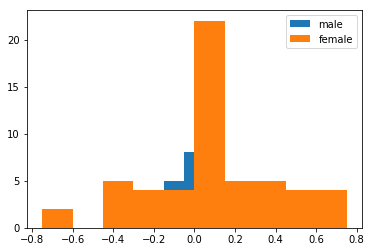

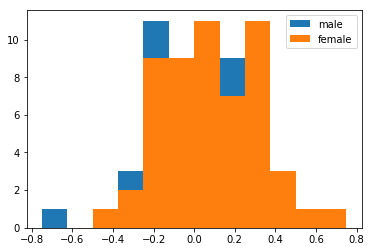

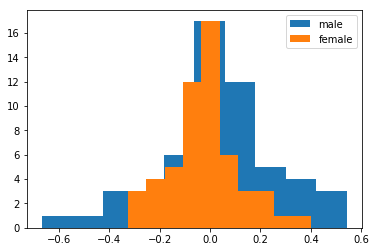

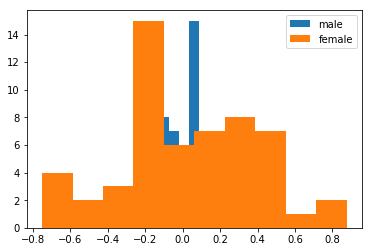

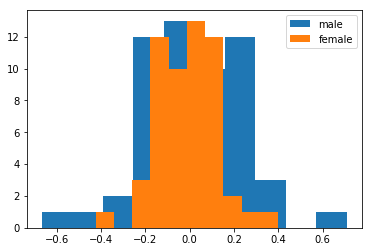

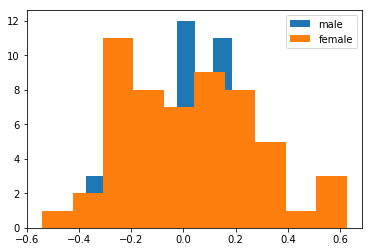

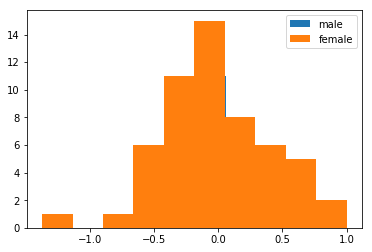

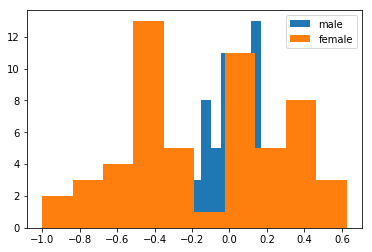

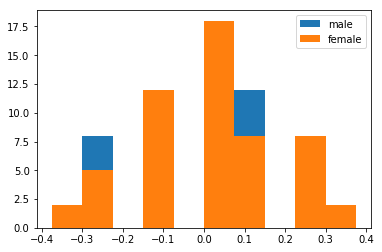

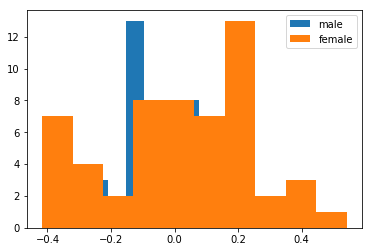

In [99]:
for BATCH_NO in BATCH_NOS:
    rep_deltas = []
    dem_deltas = []
    subj_df = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == ROUND_NO]\
                        [SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == ROUND_NO]['batch'] == BATCH_NO]\
                           .reset_index()
    for s_id in worker_labels_per_round[ROUND_NO][BATCH_NO].drop('MACE competence').index:
        av_rating = worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id]['av_rating']
        rep_workers = [w_id  for w_id in range(0,8) if 
                       subj_df.iloc[w_id]['gender'] == 'male']
        dem_workers = [w_id for w_id in range(0,8) if 
                       subj_df.iloc[w_id]['gender'] == 'female']
        if len(rep_workers) > 0 and len(dem_workers) > 0:
            av_rep_rating = np.average([label2int[l] for l in worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id][['worker_{}'.format(w_id) 
                                                                                    for w_id in rep_workers]]])
            av_dem_rating = np.average([label2int[l] for l in worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id][['worker_{}'.format(w_id) 
                                                                                    for w_id in dem_workers]]])
            av_rep_delta = av_rep_rating - av_rating
            av_dem_delta = av_dem_rating - av_rating
            rep_deltas.append(av_rep_delta)
            dem_deltas.append(av_dem_delta)
    #         all_rep_deltas.append(av_rep_delta)
    #         all_dem_deltas.append(av_dem_delta)
    plt.hist(rep_deltas,label='male')
    plt.hist(dem_deltas,label='female')
    plt.legend()
    plt.show()

In [ ]:
# t-test: is average rating higher or lower than MACE pred for 2 parties?

In [106]:
# get all republican ratings for an item and measure average delta from av_rating, for each item
# get all dem. ratings for an item and measure average delta from av_rating, for each item
# then aggregate over all items in a batch and t-test?
all_rep_deltas = []
all_dem_deltas = []
for BATCH_NO in BATCH_NOS:
    rep_deltas = []
    dem_deltas = []
    subj_df = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == ROUND_NO]\
                        [SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == ROUND_NO]['batch'] == BATCH_NO]\
                           .reset_index()
    for s_id in worker_labels_per_round[ROUND_NO][BATCH_NO].drop('MACE competence').index[5:]:
        ratings = worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id][['worker_{}'.format(w_id) 
                                                                         for w_id in range(8)]]
        rating_counts = ratings.value_counts()
        for ans in ['agrees','neutral','disagrees']:
            if ans in rating_counts:
                continue
            else:
                rating_counts[ans] = 0
        ps = [rating_counts[x]*1./rating_counts.sum() for x in ['disagrees','agrees','neutral']]
        entropy = stats.entropy(ps)
        if True:#entropy <= 0.5:
            av_rating = worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id]['av_rating']
            rep_workers = [w_id  for w_id in range(0,8) if 
                       subj_df.iloc[w_id]['party'] == 'republican']
            dem_workers = [w_id for w_id in range(0,8) if 
                       subj_df.iloc[w_id]['party'] == 'democrat']
            if len(rep_workers) > 0 and len(dem_workers) > 0:
                av_rep_rating = np.average([label2int[l] for l in worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id][['worker_{}'.format(w_id) 
                                                                                    for w_id in rep_workers]]])
                av_dem_rating = np.average([label2int[l] for l in worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id][['worker_{}'.format(w_id) 
                                                                                        for w_id in dem_workers]]])
                av_rep_delta = av_rep_rating - av_rating
                av_dem_delta = av_dem_rating - av_rating
                rep_deltas.append(av_rep_delta)
                dem_deltas.append(av_dem_delta)
                all_rep_deltas.append(av_rep_delta)
                all_dem_deltas.append(av_dem_delta)
    print('************ BATCH NO {} ************'.format(BATCH_NO))
    print(np.average(rep_deltas))
    print(np.average(dem_deltas))
    print(stats.ttest_ind(rep_deltas,dem_deltas))
    print('\n')

************ BATCH NO 0 ************
-0.03
-0.03
Ttest_indResult(statistic=0.0, pvalue=1.0)


************ BATCH NO 1 ************
0.029999999999999995
0.0033333333333333305
Ttest_indResult(statistic=0.44667267425196266, pvalue=0.6560969313546345)


************ BATCH NO 2 ************
0.0775
-0.01583333333333334
Ttest_indResult(statistic=2.035917287505684, pvalue=0.04445725362838725)


************ BATCH NO 3 ************
0.0925
0.0125
Ttest_indResult(statistic=1.0500589649275123, pvalue=0.29627357710849184)


************ BATCH NO 4 ************
0.0675
-0.012500000000000002
Ttest_indResult(statistic=0.7179413426851673, pvalue=0.47450147950458166)


************ BATCH NO 5 ************
0.022000000000000002
-0.03666666666666668
Ttest_indResult(statistic=1.284872030109486, pvalue=0.20186561446471427)


************ BATCH NO 6 ************
0.355
-0.025000000000000005
Ttest_indResult(statistic=4.354970120009624, pvalue=3.275895498271333e-05)


************ BATCH NO 7 ************
0.205
-0

In [103]:
# Gender effect?
all_rep_deltas = []
all_dem_deltas = []
for BATCH_NO in BATCH_NOS:
    rep_deltas = []
    dem_deltas = []
    subj_df = SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == ROUND_NO]\
                        [SUBJ_INFO_ALL_ROUNDS[SUBJ_INFO_ALL_ROUNDS['round'] == ROUND_NO]['batch'] == BATCH_NO]\
                           .reset_index()
    for s_id in worker_labels_per_round[ROUND_NO][BATCH_NO].drop('MACE competence').index[5:]:
        ratings = worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id][['worker_{}'.format(w_id) 
                                                                         for w_id in range(8)]]
        rating_counts = ratings.value_counts()
        for ans in ['agrees','neutral','disagrees']:
            if ans in rating_counts:
                continue
            else:
                rating_counts[ans] = 0
        ps = [rating_counts[x]*1./rating_counts.sum() for x in ['disagrees','agrees','neutral']]
        entropy = stats.entropy(ps)
        if True:#entropy <= 0.5:
            av_rating = worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id]['av_rating']
            rep_workers = [w_id  for w_id in range(0,8) if 
                       subj_df.iloc[w_id]['gender'] == 'male']
            dem_workers = [w_id for w_id in range(0,8) if 
                       subj_df.iloc[w_id]['gender'] == 'female']
            if len(rep_workers) > 0 and len(dem_workers) > 0:
                av_rep_rating = np.average([label2int[l] for l in worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id][['worker_{}'.format(w_id) 
                                                                                    for w_id in rep_workers]]])
                av_dem_rating = np.average([label2int[l] for l in worker_labels_per_round[ROUND_NO][BATCH_NO].loc[s_id][['worker_{}'.format(w_id) 
                                                                                        for w_id in dem_workers]]])
                av_rep_delta = av_rep_rating - av_rating
                av_dem_delta = av_dem_rating - av_rating
                rep_deltas.append(av_rep_delta)
                dem_deltas.append(av_dem_delta)
                all_rep_deltas.append(av_rep_delta)
                all_dem_deltas.append(av_dem_delta)
    print('************ BATCH NO {} ************'.format(BATCH_NO))
    print(np.average(rep_deltas))
    print(np.average(dem_deltas))
    print(stats.ttest_ind(rep_deltas,dem_deltas))
    print('\n')

************ BATCH NO 0 ************
-0.029999999999999992
0.09
Ttest_indResult(statistic=-2.4444715323948403, pvalue=0.01629295911557999)


************ BATCH NO 1 ************
-0.035
0.035
Ttest_indResult(statistic=-1.4142135623730951, pvalue=0.16046836332687286)


************ BATCH NO 2 ************
0.03083333333333333
-0.018499999999999996
Ttest_indResult(statistic=1.180027537294991, pvalue=0.24084571999625948)


************ BATCH NO 3 ************
-0.01083333333333333
0.0325
Ttest_indResult(statistic=-0.751178396543334, pvalue=0.4543453620790332)


************ BATCH NO 4 ************
0.007499999999999994
-0.004499999999999993
Ttest_indResult(statistic=0.3068072540216887, pvalue=0.7596410338612161)


************ BATCH NO 5 ************
-0.022
0.03666666666666666
Ttest_indResult(statistic=-1.3626834616248489, pvalue=0.17610553595512854)


************ BATCH NO 6 ************
0.0035714285714285644
-0.025
Ttest_indResult(statistic=0.419149465596467, pvalue=0.6760242143986923)


**

In [107]:
print(np.average(all_rep_deltas))
print(np.average(all_dem_deltas))

0.09820000000000001
-0.02923333333333334


In [108]:
#from scipy.stats import stats
stats.ttest_ind(all_rep_deltas,all_dem_deltas)

Ttest_indResult(statistic=5.223764178427376, pvalue=2.133886137630008e-07)

In [105]:
print(np.average(all_male_deltas))
print(np.average(all_female_deltas))

NameError: name 'all_male_deltas' is not defined

In [158]:
print(np.std(all_rep_deltas+all_dem_deltas))
print(np.std(all_dem_deltas))
print(np.std(all_rep_deltas))

0.3379884833004669
0.20933114279473564
0.4296411086067779


In [160]:
#from scipy.stats import stats
stats.ttest_ind(all_male_deltas,all_female_deltas)

Ttest_indResult(statistic=-1.1051221882872504, pvalue=0.26940264735535696)

### Power analysis

Solve for power: https://www.statsmodels.org/dev/generated/statsmodels.stats.power.tt_ind_solve_power.html

In [43]:
import statsmodels

In [348]:
mu_diff = np.average(all_rep_deltas)-np.average(all_dem_deltas)
effect_sizes = [mu_diff / sd for sd in [np.std(all_rep_deltas+all_dem_deltas),np.std(all_dem_deltas),
                                       np.std(all_rep_deltas)]]
nobs = len(all_rep_deltas)
alphas = [0.05,0.01,0.005]

In [349]:
nobs

360

In [350]:
power_dict = {'eff_size':[item for sublist in [[eff]*len(alphas) for eff in effect_sizes] for item in sublist],
             'alphas':alphas*len(effect_sizes),
             'power':[]}

In [351]:
for ix_ef_size in range(len(effect_sizes)):
    for ix_alph in range(len(alphas)):
        power_dict['power'].append(statsmodels.stats.power.tt_ind_solve_power(
            effect_size=effect_sizes[ix_ef_size],
                                          nobs1=nobs,
                                          alpha=alphas[ix_alph]))

In [352]:
pd.DataFrame(power_dict)

,eff_size,alphas,power
0,-0.008443,0.050,0.051467
1,-0.008443,0.010,0.010478
2,-0.008443,0.005,0.005279
3,-0.009528,0.050,0.051869
4,-0.009528,0.010,0.010609
5,-0.009528,0.005,0.005356
6,-0.007660,0.050,0.051208
7,-0.007660,0.010,0.010393
8,-0.007660,0.005,0.005230


We'd need 28.5k observations to achieve 80% power with the most lenient effect sizes and alpha.

In [353]:
statsmodels.stats.power.tt_ind_solve_power(
            effect_size=max(effect_sizes),
                        alpha=max(alphas),
power=0.8)

267529.2586510389

# Extras

## Matching annotations to original complement clauses

In [333]:
TRIAL_INFOS[1]['df_key'] = [pd.DataFrame(ROUND2_DATA[BATCH_NOS[1]]).set_index('sent_id').loc\
                            [trial_sent_id]['df_key'] for trial_sent_id in 
                           TRIAL_INFOS[1]['trial_sent_id']]

In [334]:
TRIAL_INFOS[1]

,option_chosen,workerid,RT,trial_sent_id,batch,df_key
0,neutral,0,7579,t13,1,3502
1,agrees,0,4729,t30,1,3526
2,agrees,0,7480,t36,1,3546
3,neutral,0,7595,t31,1,16996
4,agrees,0,7401,t29,1,16811
5,agrees,0,5645,t10,1,3691
6,neutral,0,10954,s2,1,-1
7,neutral,0,11132,s1,1,-1
8,agrees,0,20042,t25,1,3571
9,agrees,0,9387,t16,1,17015


In [494]:
pd.DataFrame(ROUND2_DATA[BATCH_NOS[1]]).set_index('sent_id')

,sentence,option1,option2,option3,condition,df_key
sent_id,,,,,,
s0,Global warming is a hoax.,agrees,disagrees,neutral,screen,-1
s1,Alarming levels of sea level rise are predicte...,agrees,disagrees,neutral,screen,-1
s2,"Over the past several years, the United States...",agrees,disagrees,neutral,screen,-1
s3,Global warming is happening and it will be dan...,agrees,disagrees,neutral,screen,-1
s4,Some icebergs are cute.,agrees,disagrees,neutral,screen,-1
t0,I’ve heard Al Gore talk about global warming s...,agrees,disagrees,neutral,true,3831
t1,Today the world's leading scientific experts c...,agrees,disagrees,neutral,true,16923
t2,"Glaciers and sea ice may have been melting, bu...",agrees,disagrees,neutral,true,17028
t3,If human CO2 emissions are a primary driver of...,agrees,disagrees,neutral,true,17034


In [493]:
data_for_mturk = pd.read_pickle('/Users/yiweiluo/dropbox/research/QP2/code/Fox_and_friends/data_for_mturk.pkl')

In [496]:
data_for_mturk.iloc[3831]['bias']

'pro'

## PILOTS

Pilot 1: Changed target to "Climate change/global warming is a serious concern."

Pilot 2: Added time lag for button appearance.

Pilot 3: Added state Q, changed to GitHub site, new Likert q "Concerns about global warming are exaggerated".

In [3]:
import json
TRIAL_SENTS = {pilot_no: [] for pilot_no in PILOTS}
with open(MTURK_RES_DIR + PILOT_DIRS[0] + 'pilot_0_main_trials.jsonlist') as f:
    lines = f.readlines()
for ix in range(0,270,9):
    line_chunk = [l.strip() for l in lines[ix:ix+9]]
    line_chunk = "".join(line_chunk)
    if line_chunk[-1] == ',':
        line_chunk = line_chunk[:-1]
    TRIAL_SENTS[0].append(json.loads(line_chunk))
with open(MTURK_RES_DIR + PILOT_DIRS[1] + 'pilot_1_trials.jsonlist') as f:
    lines = f.readlines()
for ix in range(0,270,9):
    line_chunk = [l.strip() for l in lines[ix:ix+9]]
    line_chunk = "".join(line_chunk)
    if line_chunk[-1] == ',':
        line_chunk = line_chunk[:-1]
    TRIAL_SENTS[1].append(json.loads(line_chunk))
    TRIAL_SENTS[2].append(json.loads(line_chunk))
    TRIAL_SENTS[3].append(json.loads(line_chunk))

In [4]:
sent_id_to_sent = {pilot_no: {x['sent_id']:x['sentence'] for x in TRIAL_SENTS[pilot_no]}
                   for pilot_no in PILOTS}

In [5]:
SUBJECT_INFOS = {pilot_no: pd.read_csv(MTURK_RES_DIR+PILOT_DIRS[pilot_no]+\
                                       "cc_stance_pilot_{}-subject-info.csv".format(pilot_no))
                                      for pilot_no in PILOTS}
TRIAL_INFOS = {pilot_no: pd.read_csv(MTURK_RES_DIR+PILOT_DIRS[pilot_no]+\
                                    "cc_stance_pilot_{}-trials.csv".format(pilot_no))
              for pilot_no in PILOTS}
for pilot_no in PILOTS:
    TRIAL_INFOS[pilot_no]['sentence'] = [sent_id_to_sent[pilot_no][s_id] for s_id in 
                                        TRIAL_INFOS[pilot_no]['trial_sent_id']]

In [6]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [137]:
SUBJECT_INFOS[1]

,startDate,startTime,practiceEndTime,practiceTimeSpent,comments,criticisms,HitCorrect,HitFamiliar,age,gender,education,party,languages,endTime,timeSpent,likert1,likert2,likert3,likert4,likert5,likert6,workerid
0,Thu Oct 31 2019 15:23:50 GMT-0500 (CDT),1572553430438,1572553523935,1.558283,NaN,"It was a little difficult at first, the practice helped.",0,1,35,male,graduated_college,republican,english,1572553842712,6.871233,strong_agree,disagree,strong_disagree,strong_agree,disagree,agree,A1PF01FF85HUY4
1,Thu Oct 31 2019 16:07:52 GMT-0500 (Central Daylight Time),1572556072263,1572556255260,3.049950,NaN,NaN,0,1,50,male,graduated_college,independent,English,1572556678912,10.110817,strong_agree,neutral,strong_agree,strong_agree,neutral,strong_agree,A27GRNV01G1W87
2,Thu Oct 31 2019 13:11:21 GMT-0700 (Pacific Daylight Time),1572552681039,1572552968859,4.797000,Interesting!,NaN,0,1,40,male,higher_degree,democrat,English,1572553172388,8.189150,strong_agree,neutral,strong_agree,strong_agree,disagree,disagree,AQ6IRR0EOFP8Q


In [9]:
TRIAL_INFOS[3]

,RT,trial_sent_id,workerid,trial_number,condition,option_chosen,sentence
0,3412,t12,0,1,true,disagrees,Rather than the earlier prediction of warmer a...
1,1927,t17,0,2,true,agrees,Global warming is not a crisis.
2,4590,t15,0,3,true,disagrees,About five years ago the environmental groups ...
3,2317,t2,0,4,true,neutral,The growing deluge of greenhouse gas emissions...
4,2362,t18,0,5,true,disagrees,Climate can change from both natural and anthr...
5,3629,t23,0,6,true,agrees,"On the upside, weaning ourselves off of fossil..."
6,3299,s3,0,7,screen,agrees,Global warming is happening and it will be dan...
7,2422,t10,0,8,true,disagrees,Natural gas pipelines are crucial to national ...
8,3494,t4,0,9,true,neutral,There's no longer any serious doubt that clima...
9,3142,t5,0,10,true,disagrees,Measures such as conservation won't cost much ...


In [10]:
trials_per_worker = {pilot_no: TRIAL_INFOS[pilot_no].groupby('workerid') 
                    for pilot_no in PILOTS}

In [36]:
trials_per_worker[3].get_group(0)

,RT,trial_sent_id,trial_number,condition,option_chosen,sentence
0,3412,t12,1,true,disagrees,"Rather than the earlier prediction of warmer and drier weather here, conditions would get cooler and wetter."
1,1927,t17,2,true,agrees,Global warming is not a crisis.
2,4590,t15,3,true,disagrees,About five years ago the environmental groups were supportive of natural gas technology as a cleaner alternative.
3,2317,t2,4,true,neutral,The growing deluge of greenhouse gas emissions continue.
4,2362,t18,5,true,disagrees,Climate can change from both natural and anthropogenic causes.
5,3629,t23,6,true,agrees,"On the upside, weaning ourselves off of fossil fuels will likely happen at some point, just not tomorrow."
6,3299,s3,7,screen,agrees,Global warming is happening and it will be dangerous to human health and welfare.
7,2422,t10,8,true,disagrees,Natural gas pipelines are crucial to national security.
8,3494,t4,9,true,neutral,"There's no longer any serious doubt that climate change is real, accelerating, and caused by human activities."
9,3142,t5,10,true,disagrees,Measures such as conservation won't cost much and will buy insurance against global warming.


In [11]:
for pilot_no in PILOTS:
    print('============ Pilot #{} ============'.format(pilot_no))
    print('Mean time spent:',SUBJECT_INFOS[pilot_no]['timeSpent'].mean())
    print('Max time spent:',SUBJECT_INFOS[pilot_no]['timeSpent'].max())
    print('Min time spent:',SUBJECT_INFOS[pilot_no]['timeSpent'].min())
    print('\n')

============ Pilot #0 ============
Mean time spent: 10.652593333333334
Max time spent: 15.923516666666664
Min time spent: 5.732383333333333


============ Pilot #1 ============
Mean time spent: 8.3904
Max time spent: 10.110816666666668
Min time spent: 6.8712333333333335


============ Pilot #2 ============
Mean time spent: 14.331366666666668
Max time spent: 19.788016666666667
Min time spent: 11.43975


============ Pilot #3 ============
Mean time spent: 11.220388888888891
Max time spent: 12.430766666666667
Min time spent: 10.1582




Distribution of reading times per question:

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
RT_dists = {}
for pilot_no in PILOTS:
    question_groups = TRIAL_INFOS[pilot_no].groupby('trial_sent_id')
    df = pd.DataFrame(columns=['sent_id','sentence','mean RT (seconds)','max RT','min RT'])
    for sent_id in question_groups.first().index:
        df = df.append({'sent_id':sent_id,
                  'sentence':question_groups.get_group(sent_id)['sentence'].iloc[0],
                  'mean RT (seconds)':question_groups.get_group(sent_id)['RT'].mean()/1000.,
                  'max RT':question_groups.get_group(sent_id)['RT'].max()/1000.,
                  'min RT':question_groups.get_group(sent_id)['RT'].min()/1000.},
                 ignore_index=True)
    df = df.sort_values('mean RT (seconds)',ascending=False)
    RT_dists[pilot_no] = df

In [76]:
RT_dists[0]

,sent_id,sentence,mean RT (seconds),max RT,min RT
5,t0,The term global warming is associated with gre...,45.9706,187.879,7.263
10,t13,It must decide quickly on how to comply with p...,40.1268,167.009,5.071
1,s1,Alarming levels of sea level rise are predicte...,17.0126,45.384,4.455
29,t9,That may be the only meaningful alternative to...,16.4878,31.346,2.925
23,t3,Poorer nations adapt to the impacts of global ...,16.3384,43.071,3.348
11,t14,Environmental Protection Agency regulations to...,12.3446,17.574,6.709
13,t16,A transition to cleaner fuels will happen even...,12.3092,22.362,4.741
28,t8,The forecast was based on an expected change i...,10.0344,17.399,6.327
25,t5,Measures such as conservation won't cost much ...,9.5244,14.603,6.441
9,t12,Rather than the earlier prediction of warmer a...,9.0180,15.756,5.367


In [64]:
RT_dists[1]

,sent_id,sentence,mean RT (seconds),max RT,min RT
5,t0,The term global warming is associated with gre...,45.113000,113.590,10.079
13,t16,A transition to cleaner fuels will happen even...,17.668667,27.582,7.919
29,t9,That may be the only meaningful alternative to...,15.749667,17.842,11.814
28,t8,The forecast was based on an expected change i...,13.640667,21.045,7.663
23,t3,Poorer nations adapt to the impacts of global ...,10.528000,18.413,3.414
27,t7,Even if the countries followed today's commitm...,10.180333,16.231,4.760
11,t14,Environmental Protection Agency regulations to...,10.018667,12.933,5.716
12,t15,About five years ago the environmental groups ...,9.440667,15.456,3.733
21,t23,"On the upside, weaning ourselves off of fossil...",9.271667,11.797,5.166
10,t13,It must decide quickly on how to comply with p...,8.520667,12.960,3.796


In [14]:
RT_dists[3]

,sent_id,sentence,mean RT (seconds),max RT,min RT
10,t13,It must decide quickly on how to comply with p...,22.225000,38.660,3.487
11,t14,Environmental Protection Agency regulations to...,21.024667,27.988,7.125
9,t12,Rather than the earlier prediction of warmer a...,20.089000,49.023,3.412
7,t10,Natural gas pipelines are crucial to national ...,16.185667,38.247,2.422
29,t9,That may be the only meaningful alternative to...,14.472000,23.864,3.976
23,t3,Poorer nations adapt to the impacts of global ...,13.222000,25.407,2.820
5,t0,The term global warming is associated with gre...,11.124667,15.144,5.700
22,t24,No single episode can either prove or disprove...,11.048667,19.663,2.587
2,s2,"Over the past several years, the United States...",10.388333,14.903,4.822
25,t5,Measures such as conservation won't cost much ...,10.276333,17.688,3.142


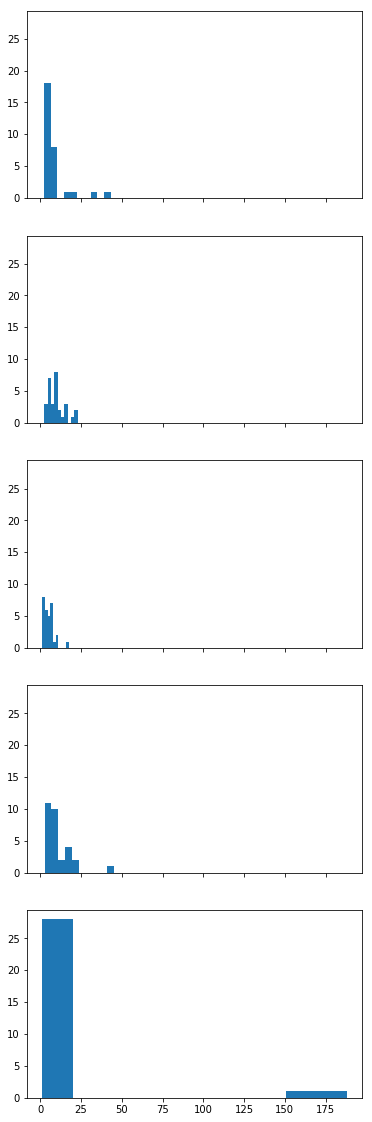

In [67]:
# Pilot 0
fig,ax_list = plt.subplots(5,1,figsize=(6,20),sharey=True,sharex=True)
for w_id in [0,1,2,3,4]:#worker_ids:
    ax_list[w_id].hist(trials_per_worker[0].get_group(w_id)['RT']/1000.)

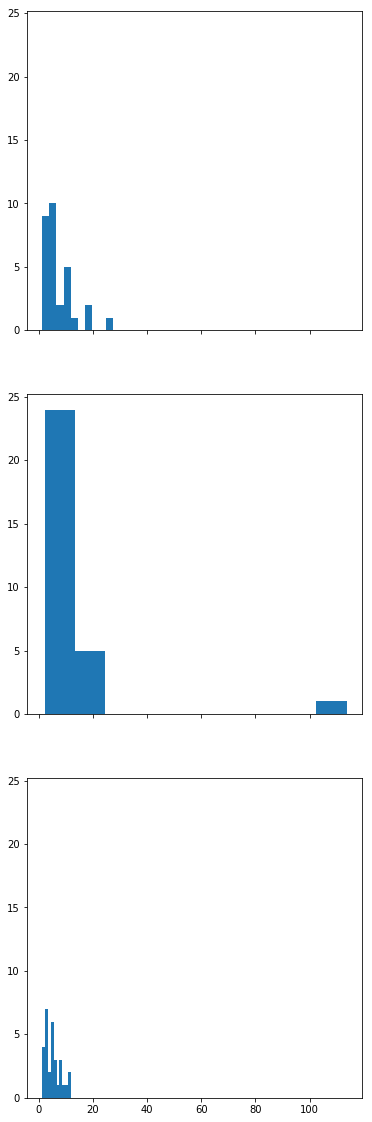

In [68]:
# Pilot 1
fig,ax_list = plt.subplots(3,1,figsize=(6,20),sharey=True,sharex=True)
for w_id in [0,1,2]:#worker_ids:
    ax_list[w_id].hist(trials_per_worker[1].get_group(w_id)['RT']/1000.)

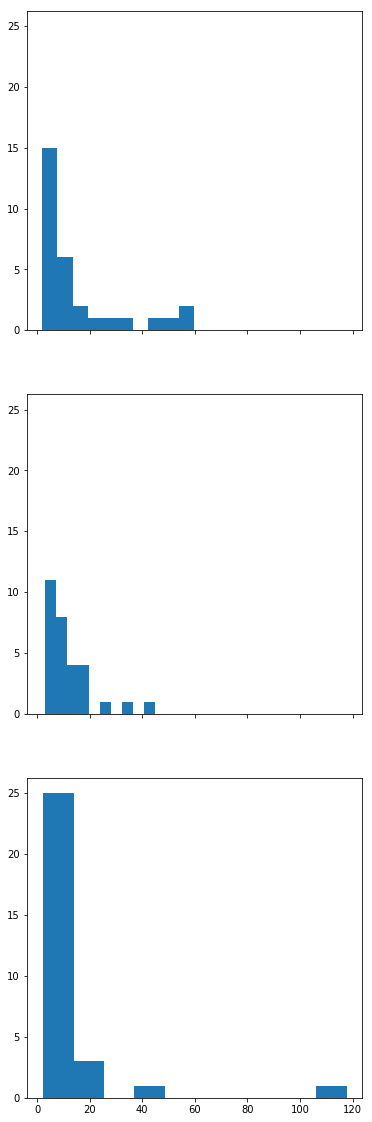

In [69]:
# Pilot 2
fig,ax_list = plt.subplots(3,1,figsize=(6,20),sharey=True,sharex=True)
for w_id in [0,1,2]:#worker_ids:
    ax_list[w_id].hist(trials_per_worker[2].get_group(w_id)['RT']/1000.)

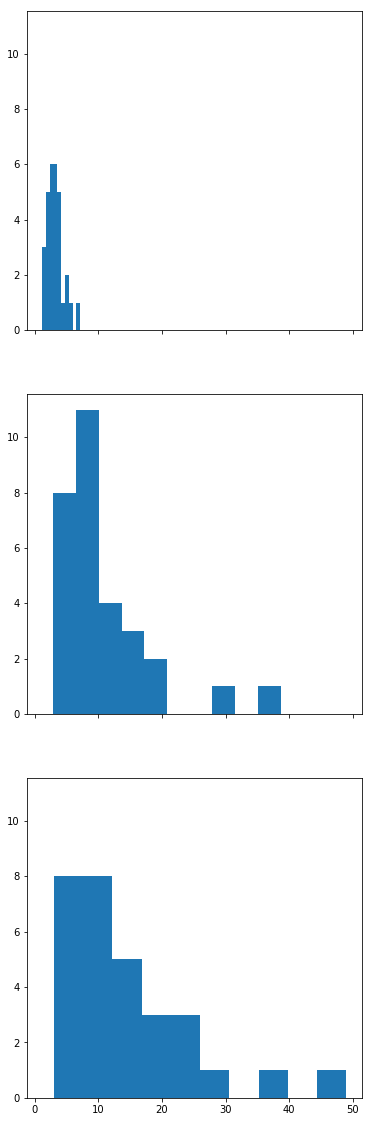

In [15]:
# Pilot 3
fig,ax_list = plt.subplots(3,1,figsize=(6,20),sharey=True,sharex=True)
for w_id in [0,1,2]:#worker_ids:
    ax_list[w_id].hist(trials_per_worker[3].get_group(w_id)['RT']/1000.)

Organize party and likert responses:

In [16]:
likert_qs_0 = ["Global average temperatures have been increasing over the past century.",
            "Humans are the primary cause of this global warming.",
            "Global warming is a natural process.",
            "Urgent government action is required to address the problem of global warming.",
            "We should continue to rely on fossil fuels as our primary source of energy.",
            "I trust the ability of news media to provide unbiased coverage of science."]
likert_qs_1 = ["Global average temperatures have been increasing over the past century.",
              "Natural temperature fluctuations account for the majority of this global warming.",
              "Humans are the primary cause of this global warming.",
              "Urgent government action is required to address the problem of global warming.",
              "We should continue to rely on fossil fuels as our primary source of energy.",
              "I trust the ability of news media to provide unbiased coverage of science."]
likert_qs_2 = ["I trust the ability of news media to provide unbiased coverage of science.",
              "Global average temperatures have been increasing over the past century.",
              "Natural temperature fluctuations account for the majority of this global warming.",
              "Humans are the primary cause of this global warming.",
              "Urgent government action is required to address the problem of global warming.",
              "We should continue to rely on fossil fuels as our primary source of energy."]
likert_qs_3 = ["I trust the ability of news media to provide unbiased coverage of science.",
              "Global average temperatures have been increasing over the past century.",
              "Concerns about global warming are exaggerated.",
              "Humans are the primary cause of global warming.",
              "Urgent government action is required to address the problem of global warming.",
              "We should continue to rely on fossil fuels as our primary source of energy."]

In [17]:
likert_df_0 = SUBJECT_INFOS[0][['likert{}'.format(ix) for ix in range(1,7)]].T
likert_df_1 = SUBJECT_INFOS[1][['likert{}'.format(ix) for ix in range(1,7)]].T
likert_df_2 = SUBJECT_INFOS[2][['likert{}'.format(ix) for ix in range(1,7)]].T
likert_df_3 = SUBJECT_INFOS[3][['likert{}'.format(ix) for ix in range(1,7)]].T

In [18]:
likert_df_0['statement'] = likert_qs_0
likert_df_1['statement'] = likert_qs_1
likert_df_2['statement'] = likert_qs_2
likert_df_3['statement'] = likert_qs_3

In [73]:
likert_df_0.set_index('statement')

,0,1,2,3,4
statement,,,,,
Global average temperatures have been increasing over the past century.,strong_agree,agree,strong_agree,agree,strong_agree
Humans are the primary cause of this global warming.,agree,strong_agree,strong_agree,strong_agree,strong_agree
Global warming is a natural process.,disagree,strong_agree,neutral,strong_agree,agree
Urgent government action is required to address the problem of global warming.,strong_agree,strong_agree,strong_agree,strong_agree,strong_agree
We should continue to rely on fossil fuels as our primary source of energy.,strong_disagree,neutral,disagree,disagree,agree
I trust the ability of news media to provide unbiased coverage of science.,strong_disagree,strong_disagree,neutral,disagree,strong_agree


In [250]:
subject_info['party']

0    republican 
1    republican 
2    democrat   
3    democrat   
4    independent
Name: party, dtype: object

In [74]:
likert_df_1.set_index('statement')

,0,1,2
statement,,,
Global average temperatures have been increasing over the past century.,strong_agree,strong_agree,strong_agree
Natural temperature fluctuations account for the majority of this global warming.,disagree,neutral,neutral
Humans are the primary cause of this global warming.,strong_disagree,strong_agree,strong_agree
Urgent government action is required to address the problem of global warming.,strong_agree,strong_agree,strong_agree
We should continue to rely on fossil fuels as our primary source of energy.,disagree,neutral,disagree
I trust the ability of news media to provide unbiased coverage of science.,agree,strong_agree,disagree


In [282]:
subject_info_1['party']

0    republican 
1    independent
2    democrat   
Name: party, dtype: object

In [75]:
likert_df_2.set_index('statement')

,0,1,2
statement,,,
I trust the ability of news media to provide unbiased coverage of science.,disagree,strong_disagree,neutral
Global average temperatures have been increasing over the past century.,strong_agree,strong_disagree,agree
Natural temperature fluctuations account for the majority of this global warming.,strong_agree,strong_agree,strong_agree
Humans are the primary cause of this global warming.,neutral,strong_disagree,neutral
Urgent government action is required to address the problem of global warming.,neutral,strong_disagree,neutral
We should continue to rely on fossil fuels as our primary source of energy.,neutral,neutral,agree


In [396]:
subject_info_2['party']

0    independent
1    independent
2    republican 
Name: party, dtype: object

In [19]:
likert_df_3.set_index('statement')

,0,1,2
statement,,,
I trust the ability of news media to provide unbiased coverage of science.,agree,strong_disagree,disagree
Global average temperatures have been increasing over the past century.,neutral,agree,neutral
Concerns about global warming are exaggerated.,strong_agree,strong_agree,strong_agree
Humans are the primary cause of global warming.,neutral,neutral,disagree
Urgent government action is required to address the problem of global warming.,strong_agree,neutral,disagree
We should continue to rely on fossil fuels as our primary source of energy.,agree,strong_disagree,strong_agree


In [20]:
SUBJECT_INFOS[3]['party']

0     republican
1    independent
2     republican
Name: party, dtype: object

In [ ]:
# statement 3 "natural process" is confusing?
# Move to first statement?
# "Natural temperature fluctuations account for observed extreme weather events and increasing temperature"

### 0. Basic summary stats

In [ ]:
worker_annotations = {}
for pilot_no in PILOTS:
    labels_per_worker = {}
    for w_id in trials_per_worker[pilot_no].first().index:
        worker_labels = trials_per_worker[pilot_no].get_group(w_id).sort_values(by='trial_sent_id')
        worker_labels = worker_labels.set_index('trial_sent_id')
        worker_labels = worker_labels.drop(["trial_number","RT","condition","sentence"],axis=1)
        #print(worker_labels)
        worker_labels.columns = ['worker_{}'.format(w_id)]
        labels_per_worker[w_id] = worker_labels
    worker_annotations[pilot_no] = labels_per_worker

In [ ]:
all_worker_labels_0 = pd.concat([worker_annotations[0][0], worker_annotations[0][1], worker_annotations[0][2], 
                               worker_annotations[0][3], worker_annotations[0][4]], axis=1)
all_worker_labels_1 = pd.concat([worker_annotations[1][0], worker_annotations[1][1], 
                                 worker_annotations[1][2]], axis=1)
all_worker_labels_2 = pd.concat([worker_annotations[2][0], worker_annotations[2][1], 
                                 worker_annotations[2][2]], axis=1)
all_worker_labels_3 = pd.concat([worker_annotations[3][0], worker_annotations[3][1], 
                                 worker_annotations[3][2]], axis=1)

In [ ]:
sent_id_to_sent_0 = {x['sent_id']:x['sentence'] for x in TRIAL_SENTS[0]}
sent_id_to_sent_1 = {x['sent_id']:x['sentence'] for x in TRIAL_SENTS[1]}

In [ ]:
all_worker_labels_0['sentence'] = [sent_id_to_sent_0[s_id] for s_id in 
                                  all_worker_labels_0.index]
all_worker_labels_1['sentence'] = [sent_id_to_sent_1[s_id] for s_id in 
                                  all_worker_labels_1.index]
all_worker_labels_2['sentence'] = [sent_id_to_sent_1[s_id] for s_id in 
                                  all_worker_labels_2.index]
all_worker_labels_3['sentence'] = [sent_id_to_sent_1[s_id] for s_id in 
                                  all_worker_labels_3.index]

In [ ]:
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS = all_worker_labels_1.iloc[5:].drop(['sentence'],axis=1)
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_3'] = all_worker_labels_2.iloc[5:].drop(['sentence'],axis=1)['worker_0']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_4'] = all_worker_labels_2.iloc[5:].drop(['sentence'],axis=1)['worker_1']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_5'] = all_worker_labels_2.iloc[5:].drop(['sentence'],axis=1)['worker_2']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_6'] = all_worker_labels_3.iloc[5:].drop(['sentence'],axis=1)['worker_0']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_7'] = all_worker_labels_3.iloc[5:].drop(['sentence'],axis=1)['worker_1']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_8'] = all_worker_labels_3.iloc[5:].drop(['sentence'],axis=1)['worker_2']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['sentence'] = [sent_id_to_sent_1[s_id] for s_id in 
                                  all_worker_labels_3.index[5:]]

In [ ]:
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['av_rating'] = [np.average(
    [label2int[COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_{}'.format(w_id)].loc[sent_id]]
     for w_id in range(0,9)]) for sent_id in COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS.index]

In [146]:
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS

,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,worker_8,sentence,av_rating,MACE_pred
trial_sent_id,,,,,,,,,,,,
t0,neutral,neutral,neutral,neutral,agrees,neutral,neutral,agrees,neutral,"The term global warming is associated with greater public understanding, emotional engagement, and support for personal and national action than the term climate change.",0.222222,neutral
t1,agrees,agrees,agrees,agrees,agrees,agrees,disagrees,agrees,agrees,The polar bear is being driven extinct by global warming.,0.777778,agrees
t10,disagrees,neutral,neutral,neutral,neutral,disagrees,disagrees,agrees,disagrees,Natural gas pipelines are crucial to national security.,-0.333333,neutral
t11,neutral,agrees,neutral,neutral,neutral,neutral,disagrees,agrees,disagrees,We cannot act until poor countries act.,0.000000,neutral
t12,disagrees,neutral,disagrees,neutral,neutral,neutral,disagrees,neutral,disagrees,"Rather than the earlier prediction of warmer and drier weather here, conditions would get cooler and wetter.",-0.444444,neutral
t13,neutral,neutral,neutral,neutral,neutral,neutral,disagrees,agrees,neutral,It must decide quickly on how to comply with proposed Environmental Protection Agency rules limiting carbon pollution.,0.000000,neutral
t14,disagrees,disagrees,neutral,neutral,neutral,neutral,disagrees,agrees,neutral,"Environmental Protection Agency regulations to curb mercury and other pollutants will force its utilities to close coal-fired plants, driving up customer bills and putting the grid's reliability at risk.",-0.222222,neutral
t15,disagrees,neutral,neutral,neutral,disagrees,disagrees,disagrees,agrees,neutral,About five years ago the environmental groups were supportive of natural gas technology as a cleaner alternative.,-0.333333,neutral
t16,disagrees,disagrees,neutral,neutral,neutral,neutral,disagrees,neutral,disagrees,"A transition to cleaner fuels will happen eventually based on natural trends in energy markets, and that forcing a change too rapidly would do more harm than good.",-0.444444,neutral


In [156]:
pd.DataFrame.from_dict({'worker': ['worker_{}'.format(w_id) for w_id in range(0,9)],
                       'competence': worker_competences}).set_index('worker').sort_values('competence')

,competence
worker,
worker_6,0.009488
worker_8,0.360171
worker_7,0.414737
worker_0,0.438071
worker_4,0.568275
worker_1,0.600761
worker_2,0.639976
worker_5,0.666692
worker_3,0.881607


In [117]:
4/40

0.1

In [121]:
# Write output for MACE
MACE_df = COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS.drop(['sentence','av_rating'],axis=1)
MACE_df = MACE_df.reset_index(drop=True)
MACE_df.to_csv('pilot_data_MACE.csv',header=None,index=False)

Read back in MACE predictions and competence scores:

In [154]:
MACE_preds = []
worker_competences = []
with open('/Users/yiweiluo/MACE/prediction','r') as f:
    for line in f:
        MACE_preds.append(line.strip())
with open('/Users/yiweiluo/MACE/competence','r') as f:
    worker_competences = f.readlines()[0].strip().split('\t')
worker_competences = [float(c) for c in worker_competences
                     ]
print(MACE_preds)
print(worker_competences)

['neutral', 'agrees', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'disagrees', 'neutral', 'disagrees', 'agrees', 'disagrees', 'disagrees', 'disagrees', 'neutral', 'neutral', 'disagrees', 'agrees', 'agrees', 'agrees', 'agrees', 'neutral', 'neutral']
[0.43807064455229355, 0.6007611429389333, 0.6399762998441413, 0.8816071905861341, 0.5682747072207643, 0.6666921577866393, 0.009488008111733705, 0.41473721737487895, 0.3601708897081276]


In [131]:
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['MACE_pred'] = MACE_preds

Plot distribution of ratings:

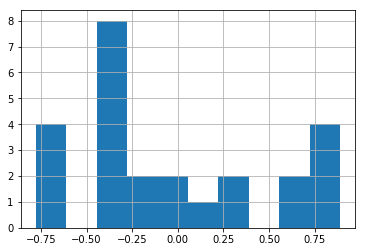

In [113]:
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['av_rating'].hist()

Examine individual worker responses:

In [ ]:
pd.set_option('display.max_colwidth', -1)
#all_worker_labels_0

### 1. Fleiss's kappa for 2+ annotators

In [7]:
trial_info.columns

Index(['trial_number', 'RT', 'condition', 'workerid', 'trial_sent_id',
       'option_chosen'],
      dtype='object')

Break trials into chunks for each annotator:

In [251]:
trials_per_worker = trial_info.groupby('workerid')

In [252]:
trials_per_worker.first()

,trial_sent_id,RT,trial_number,condition,option_chosen
workerid,,,,,
0,t9,31346,1,true,neutral
1,s2,18869,1,screen,neutral
2,t14,17574,1,true,agrees
3,t19,11048,1,true,disagrees
4,t12,6544,1,true,neutral


In [258]:
worker_ids = list(trials_per_worker.first().index)

Step 1: Calculate how many assignments went (proportionally) to each category $(P_c)$.

$$P_c=\frac{1}{Aa}\sum_{i=1}^{A}a_{ic},$$

$A =$ number of annotators,
$a =$ number of annotations each annotator created,
$a_{ic} =$ number of annotations in category $c$ for annotator $i$ 

In [254]:
A = 5
a = 30

In [255]:
P_agree = 1./(A*a)*(np.sum([np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'agrees')
                           for w_id in worker_ids]))
P_disagree = 1./(A*a)*(np.sum([np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'disagrees')
                           for w_id in worker_ids]))
P_neutral = 1./(A*a)*(np.sum([np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'neutral')
                           for w_id in worker_ids]))

In [256]:
P_neutral

0.5133333333333334

Step 2: Calculate each annotator's agreement with other annotators, compared to all possible agreement values ($P_i$):

$$P_i = \frac{(\sum_{c=1}^ka_{ic}^2)-a}{a(a-1)},$$

$k =$ number of categories.

In [257]:
k = 3

In [259]:
P_annotators = {}
for w_id in worker_ids:
    P_annotators[w_id] = (np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'agrees')**2+\
    np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'disagrees')**2+\
    np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'neutral')**2-a)/(a*(a-1.))

In [260]:
P_annotators

{0: 0.45057471264367815,
 1: 0.3195402298850575,
 2: 0.37471264367816093,
 3: 0.4850574712643678,
 4: 0.3724137931034483}

Step 3: Calculate $\bar{P}$, the average of ```P_annotators```:

In [261]:
P_av = np.mean(list(P_annotators.values()))

In [262]:
P_av

0.4004597701149425

Step 4: Calculate $\bar{P_e}$, the average of the expected agreement:

In [263]:
P_e = np.sum(P_agree**2 + P_disagree**2 + P_neutral**2)

In [264]:
P_e

0.38693333333333346

Step 5: Calculate Fleiss's kappa:

$$K = \frac{\bar{P}-\bar{P_e}}{1-\bar{P_e}}$$

In [265]:
kappa = (P_av-P_e)/(1.-P_e)

In [266]:
kappa

0.0220635658682183

"Slight agreement" within the range 0.01 - 0.20.

### 2. Correlation

Fleiss's kappa only measures agreement over category totals. Looking at correlation also gives us a p-value.

In [34]:
pd.set_option('display.max_colwidth', -1)
all_worker_labels_0

,worker_0,worker_1,worker_2,worker_3,worker_4,sentence
trial_sent_id,,,,,,
s0,disagrees,disagrees,disagrees,disagrees,disagrees,Global warming is a hoax.
s1,neutral,neutral,neutral,agrees,agrees,Alarming levels of sea level rise are predicted to threaten Florida over the next decades.
s2,neutral,neutral,neutral,neutral,neutral,The current president of the US is a republican.
s3,agrees,agrees,agrees,agrees,agrees,Global warming is happening and it will be dangerous to human health and welfare.
s4,neutral,neutral,neutral,neutral,neutral,Some dogs are cute.
t0,neutral,agrees,neutral,neutral,neutral,"The term global warming is associated with greater public understanding, emotional engagement, and support for personal and national action than the term climate change."
t1,agrees,agrees,agrees,agrees,agrees,The polar bear is being driven extinct by global warming.
t10,neutral,agrees,neutral,neutral,neutral,Natural gas pipelines are crucial to national security.
t11,neutral,agrees,neutral,neutral,neutral,We cannot act until poor countries act.


In [405]:
all_worker_labels_1

,worker_0,worker_1,worker_2,sentence
trial_sent_id,,,,
s0,disagrees,disagrees,disagrees,Global warming is a hoax.
s1,agrees,agrees,agrees,Alarming levels of sea level rise are predicted to threaten Florida over the next decades.
s2,neutral,neutral,neutral,"Over the past several years, the United States has seen an increase in business growth that has counteracted the lingering effects of the recession."
s3,agrees,agrees,agrees,Global warming is happening and it will be dangerous to human health and welfare.
s4,neutral,neutral,neutral,Some icebergs are are cute.
t0,neutral,neutral,neutral,"The term global warming is associated with greater public understanding, emotional engagement, and support for personal and national action than the term climate change."
t1,agrees,agrees,agrees,The polar bear is being driven extinct by global warming.
t10,disagrees,neutral,neutral,Natural gas pipelines are crucial to national security.
t11,neutral,agrees,neutral,We cannot act until poor countries act.


In [408]:
all_worker_labels_2

,worker_0,worker_1,worker_2,sentence
trial_sent_id,,,,
s0,disagrees,disagrees,disagrees,Global warming is a hoax.
s1,neutral,agrees,agrees,Alarming levels of sea level rise are predicted to threaten Florida over the next decades.
s2,neutral,neutral,neutral,"Over the past several years, the United States has seen an increase in business growth that has counteracted the lingering effects of the recession."
s3,agrees,agrees,agrees,Global warming is happening and it will be dangerous to human health and welfare.
s4,neutral,neutral,neutral,Some icebergs are are cute.
t0,neutral,agrees,neutral,"The term global warming is associated with greater public understanding, emotional engagement, and support for personal and national action than the term climate change."
t1,agrees,agrees,agrees,The polar bear is being driven extinct by global warming.
t10,neutral,neutral,disagrees,Natural gas pipelines are crucial to national security.
t11,neutral,neutral,neutral,We cannot act until poor countries act.


In [35]:
all_worker_labels_3

,worker_0,worker_1,worker_2,sentence
trial_sent_id,,,,
s0,neutral,disagrees,disagrees,Global warming is a hoax.
s1,disagrees,agrees,agrees,Alarming levels of sea level rise are predicted to threaten Florida over the next decades.
s2,disagrees,disagrees,neutral,"Over the past several years, the United States has seen an increase in business growth that has counteracted the lingering effects of the recession."
s3,agrees,agrees,agrees,Global warming is happening and it will be dangerous to human health and welfare.
s4,agrees,agrees,neutral,Some icebergs are are cute.
t0,neutral,agrees,neutral,"The term global warming is associated with greater public understanding, emotional engagement, and support for personal and national action than the term climate change."
t1,disagrees,agrees,agrees,The polar bear is being driven extinct by global warming.
t10,disagrees,agrees,disagrees,Natural gas pipelines are crucial to national security.
t11,disagrees,agrees,disagrees,We cannot act until poor countries act.


Step 1: Make binarized matrices for each annotator.

In [74]:
def convert_int(l):
    return int(l)

In [305]:
worker_matrices_0 = {}
worker_matrices_1 = {}

In [306]:
for w_id in worker_ids:
    label_matrix_w = pd.DataFrame.from_dict({'trial_sent_id':all_worker_labels_0.index,
                                        'agrees':list((all_worker_labels_0['worker_{}'.format(w_id)] == 'agrees').apply(convert_int)),
                                        'disagrees':list((all_worker_labels_0['worker_{}'.format(w_id)] == 'disagrees').apply(convert_int)),
                                        'neutral':list((all_worker_labels_0['worker_{}'.format(w_id)] == 'neutral').apply(convert_int))})
    label_matrix_w = label_matrix_w.set_index('trial_sent_id')
    worker_matrices_0[w_id] = label_matrix_w
for w_id in [0,1,2]:
    label_matrix_w = pd.DataFrame.from_dict({'trial_sent_id':all_worker_labels_1.index,
                                        'agrees':list((all_worker_labels_1['worker_{}'.format(w_id)] == 'agrees').apply(convert_int)),
                                        'disagrees':list((all_worker_labels_1['worker_{}'.format(w_id)] == 'disagrees').apply(convert_int)),
                                        'neutral':list((all_worker_labels_1['worker_{}'.format(w_id)] == 'neutral').apply(convert_int))})
    label_matrix_w = label_matrix_w.set_index('trial_sent_id')
    worker_matrices_1[w_id] = label_matrix_w

In [90]:
worker_matrices_0[3]

,agrees,disagrees,neutral
trial_sent_id,,,
s0,0,1,0
s1,1,0,0
s2,0,0,1
s3,1,0,0
s4,0,0,1
t0,0,0,1
t1,1,0,0
t10,0,0,1
t11,0,0,1


Step 2: Calculate spearman correlation coefficients for each worker's matrix with the other worker matrices:

In [91]:
from scipy.stats import spearmanr
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

In [ ]:
# Apply Wilcoxon signed rank test to test significance of each dimension
p_vals = np.apply_along_axis(wilcoxon, 0, corr_per_rater)[1]

In [ ]:
# Apply Bonferroni correction
reject, corr_pvals, _, newalpha = multipletests(
     p_vals, alpha=0.05, method="bonferroni") 

### 3. Krippendorff's alpha

### Pilot 0

In [273]:
data_per_coder = []
for w_id in worker_ids:
    worker_data_dict = {sent_index: label2int[all_worker_labels['worker_{}'.format(w_id)].loc[sent_index]] 
                        for sent_index in all_worker_labels.index if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [274]:
# Agreement for screen questions
krippendorff_alpha(data_per_coder)

0.8783783783783784

In [272]:
# Agreement for full questions
krippendorff_alpha(data_per_coder)

0.5345920745920746

In [275]:
# Pairwise agreements for full questions
for worker_id_a in [0,1,2,3]:
    for worker_id_b in range(worker_id_a+1,5):
        data_per_coder = []
        for w_id in [worker_id_a,worker_id_b]:
            worker_data_dict = {sent_index: label2int[all_worker_labels['worker_{}'.format(w_id)].loc[sent_index]] 
                                for sent_index in all_worker_labels.index}
            data_per_coder.append(worker_data_dict)
        print("Alpha b/w worker_{} and worker_{}:\t{}".format(worker_id_a,worker_id_b,
                                                              krippendorff_alpha(data_per_coder)))
        print('({}, {})'.format(subject_info.iloc[worker_id_a]['party'],
                                                               subject_info.iloc[worker_id_b]['party']))
        print('\n')

Alpha b/w worker_0 and worker_1:	0.5856293895191789
(republican, republican)


Alpha b/w worker_0 and worker_2:	0.32429174201326105
(republican, democrat)


Alpha b/w worker_0 and worker_3:	0.7656870532168387
(republican, democrat)


Alpha b/w worker_0 and worker_4:	0.5670446964643097
(republican, independent)


Alpha b/w worker_1 and worker_2:	0.3771593090211133
(republican, democrat)


Alpha b/w worker_1 and worker_3:	0.5986394557823129
(republican, democrat)


Alpha b/w worker_1 and worker_4:	0.47529644268774707
(republican, independent)


Alpha b/w worker_2 and worker_3:	0.5390625
(democrat, democrat)


Alpha b/w worker_2 and worker_4:	0.4813186813186814
(democrat, independent)


Alpha b/w worker_3 and worker_4:	0.7534818941504178
(democrat, independent)




### Pilot 1

In [374]:
data_per_coder = []
for w_id in [0,1,2]:#worker_ids:
    worker_data_dict = {sent_index: label2int[all_worker_labels_1['worker_{}'.format(w_id)].loc[sent_index]] 
                        for sent_index in all_worker_labels_1.index}# if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [308]:
# Agreement for screen questions
krippendorff_alpha(data_per_coder)

1.0

In [310]:
# Agreement for full questions
krippendorff_alpha(data_per_coder)

0.6261289645032556

In [311]:
# Pairwise agreements for full questions
for worker_id_a in [0,1]:
    for worker_id_b in range(worker_id_a+1,3):
        data_per_coder = []
        for w_id in [worker_id_a,worker_id_b]:
            worker_data_dict = {sent_index: label2int[all_worker_labels_1['worker_{}'.format(w_id)].loc[sent_index]] 
                                for sent_index in all_worker_labels_1.index}
            data_per_coder.append(worker_data_dict)
        print("Alpha b/w worker_{} and worker_{}:\t{}".format(worker_id_a,worker_id_b,
                                                              krippendorff_alpha(data_per_coder)))
        print('({}, {})'.format(subject_info_1.iloc[worker_id_a]['party'],
                                                               subject_info_1.iloc[worker_id_b]['party']))
        print('\n')

Alpha b/w worker_0 and worker_1:	0.6505694760820045
(republican, independent)


Alpha b/w worker_0 and worker_2:	0.6716141001855287
(republican, democrat)


Alpha b/w worker_1 and worker_2:	0.5528044466902476
(independent, democrat)




### Pilot 2

In [409]:
data_per_coder = []
for w_id in [0,1,2]:#worker_ids:
    worker_data_dict = {sent_index: label2int[all_worker_labels_2['worker_{}'.format(w_id)].loc[sent_index]] 
                        for sent_index in all_worker_labels_2.index}# if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [410]:
# Agreement for full questions
krippendorff_alpha(data_per_coder)

0.7168825266984775

In [411]:
# Pairwise agreements for full questions
for worker_id_a in [0,1]:
    for worker_id_b in range(worker_id_a+1,3):
        data_per_coder = []
        for w_id in [worker_id_a,worker_id_b]:
            worker_data_dict = {sent_index: label2int[all_worker_labels_2['worker_{}'.format(w_id)].loc[sent_index]] 
                                for sent_index in all_worker_labels_2.index}
            data_per_coder.append(worker_data_dict)
        print("Alpha b/w worker_{} and worker_{}:\t{}".format(worker_id_a,worker_id_b,
                                                              krippendorff_alpha(data_per_coder)))
        print('({}, {})'.format(subject_info_2.iloc[worker_id_a]['party'],
                                                               subject_info_2.iloc[worker_id_b]['party']))
        print('\n')

Alpha b/w worker_0 and worker_1:	0.6680306905370845
(independent, independent)


Alpha b/w worker_0 and worker_2:	0.7377777777777778
(independent, republican)


Alpha b/w worker_1 and worker_2:	0.7470223916150548
(independent, republican)




### Pilot 3

In [49]:
data_per_coder = []
for w_id in [0,1,2]:#worker_ids:
    worker_data_dict = {sent_index: label2int[all_worker_labels_3['worker_{}'.format(w_id)].loc[sent_index]] 
                        for sent_index in all_worker_labels_3.index}# if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [50]:
# Agreement for full questions
krippendorff_alpha(data_per_coder)

0.045779441797140885

In [51]:
# Pairwise agreements for full questions
for worker_id_a in [0,1]:
    for worker_id_b in range(worker_id_a+1,3):
        data_per_coder = []
        for w_id in [worker_id_a,worker_id_b]:
            worker_data_dict = {sent_index: label2int[all_worker_labels_3['worker_{}'.format(w_id)].loc[sent_index]] 
                                for sent_index in all_worker_labels_3.index}
            data_per_coder.append(worker_data_dict)
        print("Alpha b/w worker_{} and worker_{}:\t{}".format(worker_id_a,worker_id_b,
                                                              krippendorff_alpha(data_per_coder)))
        print('({}, {})'.format(SUBJECT_INFOS[3].iloc[worker_id_a]['party'],
                                                               SUBJECT_INFOS[3].iloc[worker_id_b]['party']))
        print('\n')

Alpha b/w worker_0 and worker_1:	-0.2647158897584212
(republican, independent)


Alpha b/w worker_0 and worker_2:	0.01622352410995931
(republican, republican)


Alpha b/w worker_1 and worker_2:	0.35654362416107377
(independent, republican)




### Pilots 1-3, pairwise

In [92]:
data_per_coder = []
for w_id in [0,1,2,3,4,5,6,7,8]:#worker_ids:
    worker_data_dict = {sent_index: label2int[COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_{}'.format(w_id)].loc[sent_index]] 
                        for sent_index in COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS.index}# if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [93]:
# Agreement for full questions
krippendorff_alpha(data_per_coder)

0.3940096618357488

In [94]:
list(range(0,7))

[0, 1, 2, 3, 4, 5, 6]

In [95]:
# Pairwise agreements for full questions
for worker_id_a in range(0,8):
    for worker_id_b in range(worker_id_a+1,9):
        data_per_coder = []
        for w_id in [worker_id_a,worker_id_b]:
            worker_data_dict = {sent_index: label2int[COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_{}'.format(w_id)].loc[sent_index]] 
                                for sent_index in COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS.index}
            data_per_coder.append(worker_data_dict)
        print("Alpha b/w worker_{} and worker_{}:\t{}".format(worker_id_a,worker_id_b,
                                                              krippendorff_alpha(data_per_coder)))
        print('\n')

Alpha b/w worker_0 and worker_1:	0.5756162558294471


Alpha b/w worker_0 and worker_2:	0.6037735849056605


Alpha b/w worker_0 and worker_3:	0.6259541984732824


Alpha b/w worker_0 and worker_4:	0.6715417428397319


Alpha b/w worker_0 and worker_5:	0.7270194986072424


Alpha b/w worker_0 and worker_6:	0.14449127031908493


Alpha b/w worker_0 and worker_7:	0.28985507246376807


Alpha b/w worker_0 and worker_8:	0.6806661839246922


Alpha b/w worker_1 and worker_2:	0.4551519644180876


Alpha b/w worker_1 and worker_3:	0.6984615384615385


Alpha b/w worker_1 and worker_4:	0.5426666666666666


Alpha b/w worker_1 and worker_5:	0.6671698113207547


Alpha b/w worker_1 and worker_6:	-0.34413965087281806


Alpha b/w worker_1 and worker_7:	0.48958333333333326


Alpha b/w worker_1 and worker_8:	0.5476923076923077


Alpha b/w worker_2 and worker_3:	0.64464141821112


Alpha b/w worker_2 and worker_4:	0.6939625260235947


Alpha b/w worker_2 and worker_5:	0.6975308641975309


Alpha b/w worker_2 and wo

## IAA Me and Dallas

In [327]:
dallas_jsonlist = []
me_jsonlist = []

In [330]:
with open('/Users/yiweiluo/Downloads/subsample_annotated_dbc.jsonlist') as f:
    lines = f.readlines()
for l in lines:
    l_dict = json.loads(l)
    dallas_jsonlist.append((l_dict["comp_clause"],l_dict["label"]))

In [334]:
import csv
with open('/Users/yiweiluo/scientific-debates/cc_stance/subsample_annotated_yiwei.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    for row in csvreader:
        comp_clause = row[2]
        label = row[3]
        me_jsonlist.append((comp_clause,label))

In [336]:
assert [x[0] for x in dallas_jsonlist] == [x[0] for x in me_jsonlist]

AssertionError: 

In [340]:
for ix,x in enumerate(dallas_jsonlist):
    d_cc = x[0]
    if me_jsonlist[ix][0] != d_cc:
        print(d_cc,me_jsonlist[ix][0])
        print(ix)

- The Ozark forest will change #NAME?
263


In [341]:
dallas_jsonlist[263]

('- The Ozark forest will change', 3)

In [343]:
me_jsonlist[263] = ('- The Ozark forest will change', 3)

In [344]:
assert [x[0] for x in dallas_jsonlist] == [x[0] for x in me_jsonlist]

In [381]:
me_dallas_annotations = pd.DataFrame.from_dict({
    'comp_clause':[x[0] for x in dallas_jsonlist],
    'dallas_label':[x[1] for x in dallas_jsonlist],
    'me_label':[x[1] for x in me_jsonlist]
})

In [382]:
def to_int(s):
    return int(s)

In [383]:
me_dallas_annotations['me_label'] = me_dallas_annotations['me_label'].apply(to_int)
me_dallas_annotations['dallas_label'] = me_dallas_annotations['dallas_label'].apply(to_int)

In [385]:
data_per_coder = []
for w_id in ['dallas','me']:#worker_ids:
    worker_data_dict = {index: me_dallas_annotations.iloc[index]['{}_label'.format(w_id)]
                            for index in me_dallas_annotations.index}# if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [387]:
krippendorff_alpha(data_per_coder)

0.7332962600989154